In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
path_root = "./bash_process/"
path_list = ["apps_moviles", "cuentas_con_transacciones", "cuentas_validadas","montos_procesados","operaciones_realizadas"]
df_apps_moviles = pd.read_csv(path_root+"apps_moviles.csv",encoding='latin-1')
df_cuentas_con_transacciones = pd.read_csv(path_root+"cuentas_con_transacciones.csv",encoding='latin-1')
df_cuentas_validadas = pd.read_csv(path_root+"cuentas_validadas.csv",encoding='latin-1')
df_montos_procesados = pd.read_csv(path_root+"montos_procesados.csv",encoding='latin-1')
df_operaciones_realizadas = pd.read_csv(path_root+"operaciones_realizadas.csv",encoding='latin-1')
df_montos_procesados.drop(columns=["Total de monto enviado","Total de monto recibido"], inplace=True)
df_operaciones_realizadas.drop(columns=["Total de operaciones enviadas","Total de operaciones recibidas"], inplace=True)
df_cuentas_validadas.drop(columns=["Total de cuentas validadas"], inplace=True)

In [3]:
def procesar_df_bancario_generalizado(
    df: pd.DataFrame,
    columna_fecha: str = "Título",
    keyword: str = "por",
    top_n: int = 5,
    nombre_valor: str = "valor",
    promedio_entrada_salida: bool = False,
    keywords_entrada_salida: tuple = ("enviado por", "recibido por")
) -> pd.DataFrame:
    """
    Procesa un DataFrame bancario:
    - Si `promedio_entrada_salida` es True: Promedia columnas (como operaciones/montos enviadas y recibidas)
    - Si es False: trata el DataFrame como cuentas validadas (una sola entrada por banco)
    - Convierte a largo
    - Clasifica top N bancos; el resto como "Otros"
    - Agrega por mes
    - Devuelve DataFrame wide mensual (una columna por banco)
    """

    df = df.copy()
    df.columns = df.columns.str.strip()
    df[columna_fecha] = pd.to_datetime(df[columna_fecha], errors='coerce')

    if promedio_entrada_salida:
        # Filtrar columnas de entrada y salida
        cols_env = [col for col in df.columns if keywords_entrada_salida[0] in col]
        cols_rec = [col for col in df.columns if keywords_entrada_salida[1] in col]
        cols_env.sort()
        cols_rec.sort()

        bancos = [
            col.replace(f'Operaciones {keywords_entrada_salida[0]} ', '')
               .replace(f'Monto {keywords_entrada_salida[0]} ', '')
            for col in cols_env
        ]

        df_prom = pd.DataFrame()
        df_prom[columna_fecha] = df[columna_fecha]
        for ce, cr, banco in zip(cols_env, cols_rec, bancos):
            df_prom[banco] = df[[ce, cr]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

        df_long = df_prom.melt(id_vars=columna_fecha, var_name='banco', value_name=nombre_valor)

    else:
        # Caso cuentas validadas (una sola columna por banco)
        columnas_banco = [col for col in df.columns if keyword in col and col != columna_fecha]
        df_bancos = df[[columna_fecha] + columnas_banco].copy()
        for col in columnas_banco:
            df_bancos[col] = pd.to_numeric(df_bancos[col], errors='coerce')
        df_long = df_bancos.melt(id_vars=columna_fecha, var_name='banco', value_name=nombre_valor)
        # Limpiar nombre de banco
        df_long['banco'] = df_long['banco'].str.replace("Cuentas validadas de ", "", regex=False)

    # Clasificar top bancos
    top_bancos = df_long.groupby('banco')[nombre_valor].sum().sort_values(ascending=False).head(top_n).index
    df_long['banco_simplificado'] = df_long['banco'].apply(lambda x: x if x in top_bancos else 'Otros')

    # Agregar a nivel mensual
    # df_long['fecha'] = df_long[columna_fecha].dt.to_period('M').dt.to_timestamp('s')
    df_grouped = df_long.groupby([columna_fecha, 'banco_simplificado'])[nombre_valor].sum().reset_index()

    # Formato wide final
    df_wide = df_grouped.pivot(index=columna_fecha, columns='banco_simplificado', values=nombre_valor).reset_index()
    df_wide.columns.name = None
    return df_wide


In [4]:
df_operaciones_realizadas = procesar_df_bancario_generalizado(
    df_operaciones_realizadas,
    nombre_valor="operaciones_promedio",
    promedio_entrada_salida=True,
    top_n=4,
    keywords_entrada_salida=("enviadas por", "recibidas por")
)

df_montos_procesados = procesar_df_bancario_generalizado(
    df_montos_procesados,
    nombre_valor="monto_promedio",
    promedio_entrada_salida=True,
    top_n=4,
    keywords_entrada_salida=("enviado por", "recibido por")
)

df_cuentas_validadas = procesar_df_bancario_generalizado(
    df_cuentas_validadas,
    nombre_valor="cuentas_validadas",
    promedio_entrada_salida=False,
    top_n=4,
    keyword="validadas de"
)

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_1705/3671022641.py:22: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[columna_fecha] = pd.to_datetime(df[columna_fecha], errors='coerce')
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_1705/3671022641.py:22: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[columna_fecha] = pd.to_datetime(df[columna_fecha], errors='coerce')
/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_1705/3671022641.py:22: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[columna_fecha] = pd.to_datetime(df[columna_fecha], errors='coerce')


In [5]:
df_apps_moviles = df_apps_moviles[["Título","Total de dispositivos Android enrolados","Total de dispositivos iOS enrolados"]]
df_apps_moviles.columns = ["fecha","dispositivos_android","dispositivos_ios"]
df_cuentas_con_transacciones.columns = ["fecha","cuentas_pago","cuentas_cobro"]
#df_cuentas_validadas = df_cuentas_validadas[["Título", "Total de cuentas validadas"]]
#df_cuentas_validadas.columns = ["fecha","cuentas_validadas"]
df_cuentas_validadas.columns = ["fecha","cuentas_bbva","cuentas_bancoppel","cuentas_azteca","cuentas_otros","cuentas_stp"]
# df_montos_procesados = df_montos_procesados[["Título",	"Total de monto enviado","Total de monto recibido"]]
df_montos_procesados.columns = ["fecha","monto_bbva","monto_bancoppel","monto_azteca","monto_otros","monto_stp"]
#df_operaciones_realizadas = df_operaciones_realizadas[["Título", "Total de operaciones enviadas", "Total de operaciones recibidas"]]
#df_operaciones_realizadas.columns = ["fecha", "operaciones_enviadas", "operaciones_recibidas"]
df_operaciones_realizadas.columns = ["fecha", "operaciones_bbva", "operaciones_bancoppel", "operaciones_azteca", "operaciones_otros", "operaciones_stp"]

In [6]:
class DataCleaner:
    """
    Clase de limpieza de datasets para diferentes fuentes.
    Cada método recibe un dataframe y devuelve uno limpio.
    """

    @staticmethod
    def clean_apps_moviles(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y', errors='coerce')
        for col in ['dispositivos_android', 'dispositivos_ios']:
            df[col] = pd.to_numeric(df[col].replace('N/E', np.nan), errors='coerce')
        df = df.sort_values('fecha').reset_index(drop=True)
        return df

    @staticmethod
    def clean_cuentas_con_transacciones(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y', errors='coerce')
        for col in ['cuentas_pago', 'cuentas_cobro']:
            df[col] = pd.to_numeric(df[col].replace('N/E', np.nan), errors='coerce')
        df = df.sort_values('fecha').reset_index(drop=True)
        return df

    @staticmethod
    def clean_cuentas_validadas(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y', errors='coerce')
        columns_to_clean = [col for col in df.columns if col != 'fecha']
        for col in columns_to_clean:
            df[col] = pd.to_numeric(df[col].replace('N/E', np.nan), errors='coerce')
        df = df.sort_values('fecha').reset_index(drop=True)
        return df

    @staticmethod
    def clean_montos_procesados(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y', errors='coerce')
        columns_to_clean = [col for col in df.columns if col != 'fecha']
        for col in columns_to_clean:
            df[col] = pd.to_numeric(df[col].replace('N/E', np.nan), errors='coerce')
        df = df.sort_values('fecha').reset_index(drop=True)
        return df

    @staticmethod
    def clean_operaciones_realizadas(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y', errors='coerce')
        columns_to_clean = [col for col in df.columns if col != 'fecha']
        for col in columns_to_clean:
            df[col] = pd.to_numeric(df[col].replace('N/E', np.nan), errors='coerce')
        df = df.sort_values('fecha').reset_index(drop=True)
        return df
    
def agregar_mensual(df, metodo='sum', columna_fecha='fecha'):
    """
    Agrega un DataFrame a nivel mensual.

    Parámetros:
    - df: DataFrame con columna de fecha y datos numéricos.
    - metodo: 'sum' para flujos diarios, 'last' para acumulados.
    - columna_fecha: nombre de la columna de fecha.

    Retorna:
    - DataFrame con frecuencia mensual, fecha ajustada al inicio del mes.
    """
    df = df.copy()
    df[columna_fecha] = pd.to_datetime(df[columna_fecha])
    df.set_index(columna_fecha, inplace=True)
    
    if metodo == 'sum':
        df_mensual = df.resample('M').sum()
    elif metodo == 'last':
        df_mensual = df.resample('M').last()
    else:
        raise ValueError("Método debe ser 'sum' o 'last'.")

    # Ajustar el índice al primer día del mes ('s' de 'start')
    df_mensual.index = df_mensual.index.to_period('M').to_timestamp(how='s')
    
    return df_mensual


# La función ya está lista para usarse en tu flujo. ¿Quieres aplicarla ahora a todos los datasets?

# Ejemplo de uso para todos los DataFrames
# (estos nombres deben coincidir con los cargados en tu entorno de trabajo)

# Volumen acumulado → usar 'last'
# Flujos diarios → usar 'sum'

# df_apps_moviles → acumulado
# df_cuentas_con_transacciones → acumulado
# df_cuentas_validadas → flujo
# df_operaciones_realizadas → flujo
# df_montos_procesados → flujo

# Código para aplicar la función (descomenta cuando lo uses en tu entorno):
# df_apps_moviles_mensual = agregar_mensual(df_apps_moviles, metodo='last')
# df_cuentas_con_transacciones_mensual = agregar_mensual(df_cuentas_con_transacciones, metodo='last')
# df_cuentas_validadas_mensual = agregar_mensual(df_cuentas_validadas, metodo='sum')
# df_operaciones_realizadas_mensual = agregar_mensual(df_operaciones_realizadas, metodo='sum')
# df_montos_procesados_mensual = agregar_mensual(df_montos_procesados, metodo='sum')




In [7]:
df_apps_moviles = DataCleaner.clean_apps_moviles(df_apps_moviles)
df_cuentas_con_transacciones = DataCleaner.clean_cuentas_con_transacciones(df_cuentas_con_transacciones)
df_cuentas_validadas = DataCleaner.clean_cuentas_validadas(df_cuentas_validadas)
df_montos_procesados = DataCleaner.clean_montos_procesados(df_montos_procesados)
df_operaciones_realizadas = DataCleaner.clean_operaciones_realizadas(df_operaciones_realizadas)

In [8]:
df_apps_moviles

,fecha,dispositivos_android,dispositivos_ios
0,2019-11-01,NaN,NaN
1,2019-11-11,"837,202.00","264,012.00"
2,2019-11-12,"852,648.00","274,706.00"
3,2019-11-13,"869,197.00","283,150.00"
4,2019-11-14,"885,713.00","291,600.00"
...,...,...,...
1985,2025-04-17,"21,614,477.00","8,894,554.00"
1986,2025-04-18,"21,618,185.00","8,896,492.00"
1987,2025-04-19,"21,621,479.00","8,898,324.00"
1988,2025-04-20,"21,624,539.00","8,900,136.00"


# 📊 Exploratory Data Analysis (EDA) - Datos CoDi (Banxico)

## 🧹 Limpiezas Realizadas
- Conversión de columna `fecha` a tipo `datetime`.
- Reemplazo de valores `"N/E"` por `NaN`.
- Conversión de columnas numéricas a `float`.
- Ordenamiento ascendente por fecha.
- Se respetaron las observaciones específicas de cada dataset basadas en la documentación de Banxico.

---

# 📚 Resumen General de los DataFrames

| DataFrame | Tipo de dato | Unidad | Particularidades importantes |
|:----------|:-------------|:-------|:------------------------------|
| `df_apps_moviles` | Volumen acumulado | Dispositivos | Cambio de frecuencia, baja de bancos |
| `df_cuentas_validadas` | Flujos diarios | Cuentas | Altas/bajas, días negativos |
| `df_cuentas_con_transacciones` | Volumen acumulado | Cuentas | SPEI días operativos, días nulos |
| `df_operaciones_realizadas` | Flujos diarios | Operaciones | Preliminar último día, ajustes históricos |
| `df_montos_procesados` | Flujos diarios | Pesos | Preliminar último día, ajustes históricos |

---

# 📋 EDA Detallado por Dataset

## 1. `df_apps_moviles`
**Apps móviles enroladas en CoDi**  
- **Periodo:** 11/11/2019 - 21/04/2025
- **Columnas:** `fecha`, `dispositivos_android`, `dispositivos_ios`
- **Unidad:** Volumen (conteo acumulado)

**Observaciones:**
- Volumen debería incrementar con el tiempo, salvo bajas como la de Banco Famsa (17/dic/2020).
- Entre nov 2019 y mayo 2020, el reporte no era diario.
- Reporte diario desde el 23/mayo/2020.
- Apertura/cierre de SPEI afecta interpretación de días.

**Riesgos:**
- Días planos o con retrocesos por baja de participantes.
- Interpretar bien días no operativos o nulos.

---

## 2. `df_cuentas_validadas`
**Cuentas validadas para generar cobros**  
- **Periodo:** 24/05/2020 - 21/04/2025
- **Columnas:** `fecha`, `cuentas_validadas`
- **Unidad:** Flujos diarios

**Observaciones:**
- Flujo de altas/bajas de cuentas.
- A partir del 8/jun/2020, solo cuentas activas ligadas a dispositivos.
- A partir del 25/ago/2020, se reportan únicamente altas/bajas diarias.

**Riesgos:**
- Cifras negativas representan cuentas desactivadas.
- No hay datos antes del 24/mayo/2020.

---

## 3. `df_cuentas_con_transacciones`
**Cuentas que realizaron al menos una transacción**  
- **Periodo:** 23/10/2019 - 21/04/2025
- **Columnas:** `fecha`, `cuentas_pago`, `cuentas_cobro`
- **Unidad:** Volumen acumulado

**Observaciones:**
- Reporte de cuentas que realizaron pagos o cobros.
- Basado en día operativo SPEI.
- Valores deberían crecer a lo largo del tiempo.

**Riesgos:**
- Nulos en días feriados o no operativos.

---

## 4. `df_operaciones_realizadas`
**Número de operaciones realizadas a través de CoDi**  
- **Periodo:** 30/09/2019 - 21/04/2025
- **Columnas:** `fecha`, `operaciones_enviadas`, `operaciones_recibidas`
- **Unidad:** Flujos diarios

**Observaciones:**
- Mide cantidad de operaciones cada día.
- El último dato de cada año puede ser preliminar.
- Cambios históricos aplicados en marzo 2021.

**Riesgos:**
- Último día debe tratarse con precaución.
- Revisar anomalías por ajustes históricos.

---

## 5. `df_montos_procesados`
**Monto de dinero procesado a través de CoDi**  
- **Periodo:** 30/09/2019 - 21/04/2025
- **Columnas:** `fecha`, `monto_enviado`, `monto_recibido`
- **Unidad:** Pesos mexicanos

**Observaciones:**
- Mide montos procesados diariamente.
- Último dato preliminar.
- Cambios aplicados en marzo 2021.

**Riesgos:**
- Preliminaridad del último registro.
- Análisis de montos atípicos a lo largo del tiempo.

---


In [9]:
def eda_cuantitativo(df, nombre_df):
    
    print(f"\n📄 Análisis del DataFrame: {nombre_df}")
    print("="*60)
    
    # Tamaño
    print(f"➡️  Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
    
    # Tipos de datos
    print("\n➡️  Tipos de datos:")
    print(df.dtypes)
    
    # Estadísticas descriptivas
    print("\n➡️  Estadísticas descriptivas:")
    display(df.describe(include='all'))
    
    # Porcentaje de valores nulos
    print("\n➡️  Porcentaje de valores nulos por columna:")
    print((df.isnull().mean() * 100).round(2).astype(str) + " %")
    
    # Fechas mínima y máxima (si existe columna 'fecha')
    if 'fecha' in df.columns:
        print("\n➡️  Rango de fechas:")
        print(f"Desde: {df['fecha'].min()}  Hasta: {df['fecha'].max()}")
    
    print("="*60)

# Ejecución para cada uno de tus DataFrames ya limpios:

eda_cuantitativo(df_apps_moviles, "df_apps_moviles")
eda_cuantitativo(df_cuentas_validadas, "df_cuentas_validadas")
eda_cuantitativo(df_cuentas_con_transacciones, "df_cuentas_con_transacciones")
eda_cuantitativo(df_montos_procesados, "df_montos_procesados")
eda_cuantitativo(df_operaciones_realizadas, "df_operaciones_realizadas")



📄 Análisis del DataFrame: df_apps_moviles
➡️  Dimensiones: 1990 filas × 3 columnas

➡️  Tipos de datos:
fecha                   datetime64[ns]
dispositivos_android           float64
dispositivos_ios               float64
dtype: object

➡️  Estadísticas descriptivas:


,fecha,dispositivos_android,dispositivos_ios
count,1990,"1,924.00","1,924.00"
mean,2022-07-31 11:53:29.246231296,"13,337,385.62","4,980,012.02"
min,2019-11-01 00:00:00,"837,202.00","264,012.00"
25%,2021-03-21 06:00:00,"8,614,876.50","2,759,523.75"
50%,2022-07-31 12:00:00,"14,343,112.00","5,079,981.00"
75%,2023-12-10 18:00:00,"18,868,842.00","7,282,193.25"
max,2025-04-21 00:00:00,"21,629,785.00","8,903,455.00"
std,NaN,"6,148,248.62","2,617,308.84"



➡️  Porcentaje de valores nulos por columna:
fecha                    0.0 %
dispositivos_android    3.32 %
dispositivos_ios        3.32 %
dtype: object

➡️  Rango de fechas:
Desde: 2019-11-01 00:00:00  Hasta: 2025-04-21 00:00:00

📄 Análisis del DataFrame: df_cuentas_validadas
➡️  Dimensiones: 1789 filas × 6 columnas

➡️  Tipos de datos:
fecha                datetime64[ns]
cuentas_bbva                float64
cuentas_bancoppel           float64
cuentas_azteca              float64
cuentas_otros               float64
cuentas_stp                 float64
dtype: object

➡️  Estadísticas descriptivas:


,fecha,cuentas_bbva,cuentas_bancoppel,cuentas_azteca,cuentas_otros,cuentas_stp
count,1789,"1,789.00","1,789.00","1,789.00","1,789.00","1,789.00"
mean,2022-11-05 15:34:30.653996800,"6,024.99","1,534.71",352.49,"1,302.03","1,140.59"
min,2020-05-24 00:00:00,"-10,396.00",-549.00,"-3,425.00","-1,085,669.00","-170,816.00"
25%,2021-08-14 00:00:00,"2,494.00",556.00,292.00,796.00,"1,018.00"
50%,2022-11-04 00:00:00,"6,163.00",800.00,382.00,"1,076.00","1,175.00"
75%,2024-01-30 00:00:00,"8,425.00","2,353.00",430.00,"1,450.00","1,356.00"
max,2025-04-21 00:00:00,"35,259.00","26,813.00","1,438.00","1,088,807.00","172,319.00"
std,NaN,"4,214.58","1,780.74",158.28,"36,385.44","6,907.43"



➡️  Porcentaje de valores nulos por columna:
fecha                0.0 %
cuentas_bbva         0.0 %
cuentas_bancoppel    0.0 %
cuentas_azteca       0.0 %
cuentas_otros        0.0 %
cuentas_stp          0.0 %
dtype: object

➡️  Rango de fechas:
Desde: 2020-05-24 00:00:00  Hasta: 2025-04-21 00:00:00

📄 Análisis del DataFrame: df_cuentas_con_transacciones
➡️  Dimensiones: 2008 filas × 3 columnas

➡️  Tipos de datos:
fecha            datetime64[ns]
cuentas_pago            float64
cuentas_cobro           float64
dtype: object

➡️  Estadísticas descriptivas:


,fecha,cuentas_pago,cuentas_cobro
count,2008,"1,833.00","1,833.00"
mean,2022-07-22 12:00:00.000000256,"1,138,851.46","698,172.88"
min,2019-10-23 00:00:00,"19,089.00","17,717.00"
25%,2021-03-07 18:00:00,"583,411.00","504,898.00"
50%,2022-07-22 12:00:00,"1,103,705.00","769,088.00"
75%,2023-12-06 06:00:00,"1,729,540.00","979,526.00"
max,2025-04-21 00:00:00,"2,323,772.00","1,070,218.00"
std,NaN,"676,446.98","315,835.42"



➡️  Porcentaje de valores nulos por columna:
fecha             0.0 %
cuentas_pago     8.72 %
cuentas_cobro    8.72 %
dtype: object

➡️  Rango de fechas:
Desde: 2019-10-23 00:00:00  Hasta: 2025-04-21 00:00:00

📄 Análisis del DataFrame: df_montos_procesados
➡️  Dimensiones: 2031 filas × 6 columnas

➡️  Tipos de datos:
fecha              datetime64[ns]
monto_bbva                float64
monto_bancoppel           float64
monto_azteca              float64
monto_otros               float64
monto_stp                 float64
dtype: object

➡️  Estadísticas descriptivas:


,fecha,monto_bbva,monto_bancoppel,monto_azteca,monto_otros,monto_stp
count,2031,"2,031.00","2,031.00","2,031.00","2,031.00","2,031.00"
mean,2022-07-11 00:00:00,"1,090,257.89","1,417,923.65","461,915.96","2,932,688.96","1,249,026.76"
min,2019-09-30 00:00:00,"1,752.50","7,003.50",883.00,"149,905.50",0.00
25%,2021-02-18 12:00:00,"301,876.75","611,987.50","143,942.75","1,863,875.25","110,316.00"
50%,2022-07-11 00:00:00,"716,761.50","1,010,882.50","325,058.00","3,077,585.00","546,011.50"
75%,2023-11-30 12:00:00,"1,693,242.75","2,103,618.25","755,317.75","3,863,450.75","1,921,154.75"
max,2025-04-21 00:00:00,"5,780,381.00","7,605,982.00","1,768,425.50","6,632,733.50","30,928,972.50"
std,NaN,"1,032,915.60","1,121,664.68","397,889.13","1,293,341.59","1,936,750.36"



➡️  Porcentaje de valores nulos por columna:
fecha              0.0 %
monto_bbva         0.0 %
monto_bancoppel    0.0 %
monto_azteca       0.0 %
monto_otros        0.0 %
monto_stp          0.0 %
dtype: object

➡️  Rango de fechas:
Desde: 2019-09-30 00:00:00  Hasta: 2025-04-21 00:00:00

📄 Análisis del DataFrame: df_operaciones_realizadas
➡️  Dimensiones: 2031 filas × 6 columnas

➡️  Tipos de datos:
fecha                    datetime64[ns]
operaciones_bbva                float64
operaciones_bancoppel           float64
operaciones_azteca              float64
operaciones_otros               float64
operaciones_stp                 float64
dtype: object

➡️  Estadísticas descriptivas:


,fecha,operaciones_bbva,operaciones_bancoppel,operaciones_azteca,operaciones_otros,operaciones_stp
count,2031,"2,031.00","2,031.00","2,031.00","2,031.00","2,031.00"
mean,2022-07-11 00:00:00,"1,486.11","1,599.76",628.28,"3,338.12",712.90
min,2019-09-30 00:00:00,12.50,42.50,5.50,315.50,0.00
25%,2021-02-18 12:00:00,570.25,728.00,205.00,"2,077.50",96.00
50%,2022-07-11 00:00:00,"1,263.00","1,509.50",542.00,"3,189.00",438.50
75%,2023-11-30 12:00:00,"2,178.25","2,197.50","1,009.75","4,580.75","1,206.75"
max,2025-04-21 00:00:00,"9,539.50","9,909.00","1,890.50","7,187.00","3,718.00"
std,NaN,"1,154.34","1,112.50",467.14,"1,506.31",727.55



➡️  Porcentaje de valores nulos por columna:
fecha                    0.0 %
operaciones_bbva         0.0 %
operaciones_bancoppel    0.0 %
operaciones_azteca       0.0 %
operaciones_otros        0.0 %
operaciones_stp          0.0 %
dtype: object

➡️  Rango de fechas:
Desde: 2019-09-30 00:00:00  Hasta: 2025-04-21 00:00:00


In [10]:
def plot_evolucion(df, columnas, titulo, ylabel, xlabel="Fecha", figsize=(10,4)):
    """
    Grafica evolución temporal de una o más columnas de un dataframe.
    """
    plt.figure(figsize=figsize)
    for col in columnas:
        sns.lineplot(data=df, x='fecha', y=col, label=col)

    plt.title(titulo, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


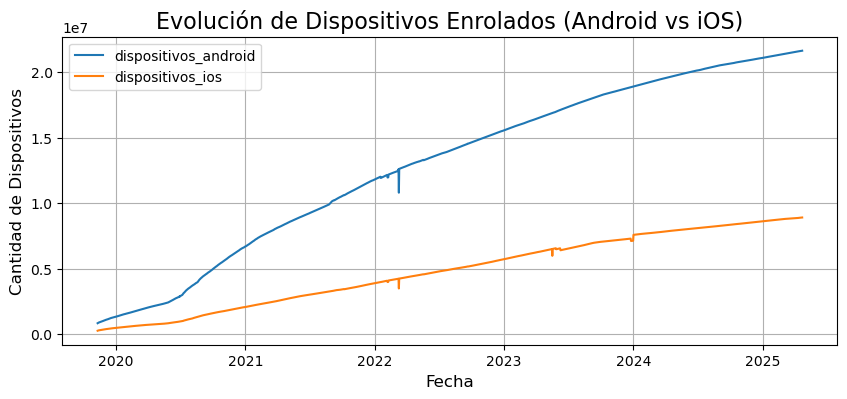

In [11]:
plot_evolucion(
    df_apps_moviles,
    columnas=['dispositivos_android', 'dispositivos_ios'],
    titulo="Evolución de Dispositivos Enrolados (Android vs iOS)",
    ylabel="Cantidad de Dispositivos"
)




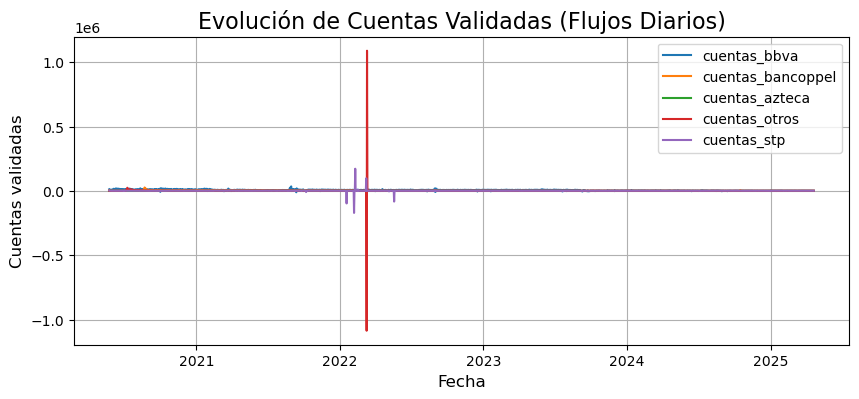

In [15]:
plot_evolucion(
    df_cuentas_validadas,
    columnas=['cuentas_bbva', 'cuentas_bancoppel', 'cuentas_azteca','cuentas_otros', 'cuentas_stp'],
    titulo="Evolución de Cuentas Validadas (Flujos Diarios)",
    ylabel="Cuentas validadas"
)

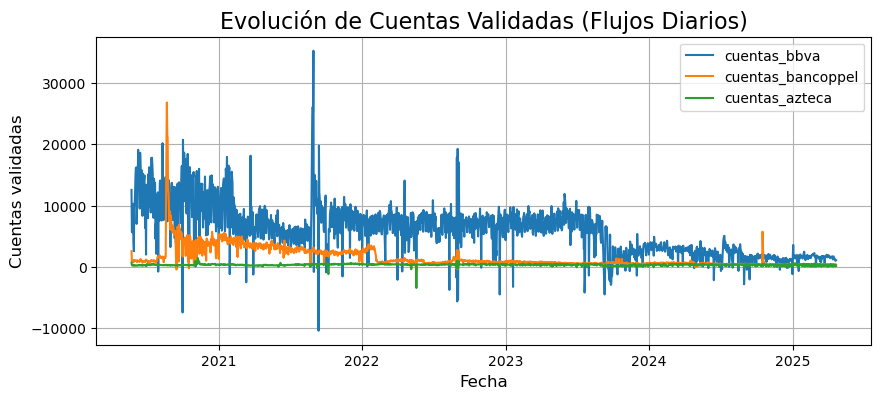

In [16]:
plot_evolucion(
    df_cuentas_validadas,
    columnas=['cuentas_bbva', 'cuentas_bancoppel', 'cuentas_azteca'],
    titulo="Evolución de Cuentas Validadas (Flujos Diarios)",
    ylabel="Cuentas validadas"
)

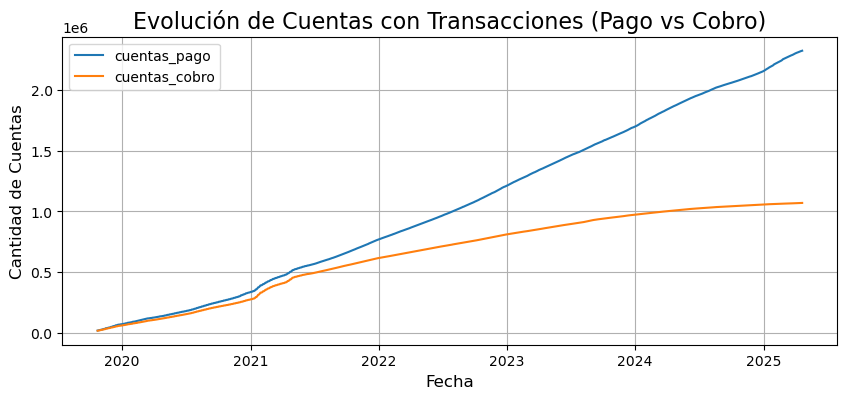

In [17]:
plot_evolucion(
    df_cuentas_con_transacciones,
    columnas=['cuentas_pago', 'cuentas_cobro'],
    titulo="Evolución de Cuentas con Transacciones (Pago vs Cobro)",
    ylabel="Cantidad de Cuentas"
)

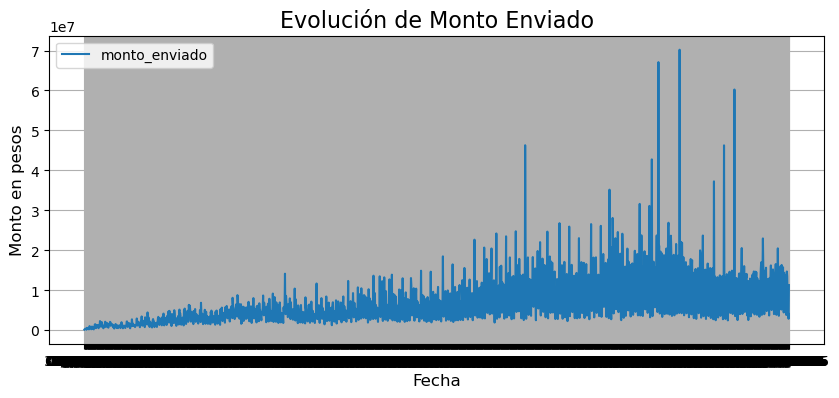

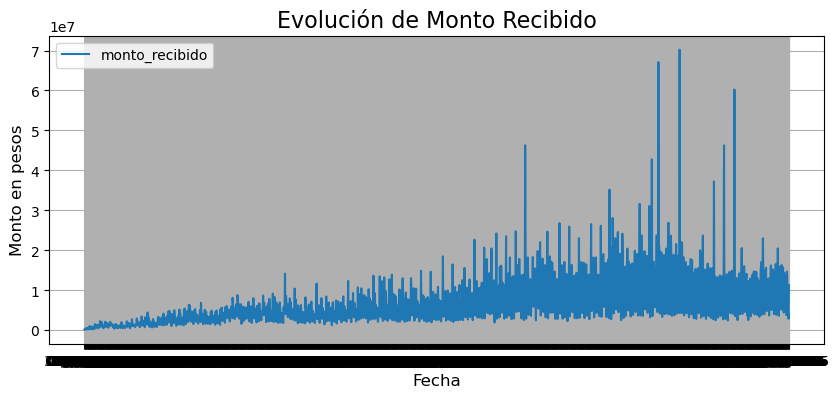

In [25]:
# Gráfica separada: Monto Enviado
plot_evolucion(
    df_montos_procesados,
    columnas=['monto_enviado'],
    titulo="Evolución de Monto Enviado",
    ylabel="Monto en pesos"
)

# Gráfica separada: Monto Recibido
plot_evolucion(
    df_montos_procesados,
    columnas=['monto_recibido'],
    titulo="Evolución de Monto Recibido",
    ylabel="Monto en pesos"
)



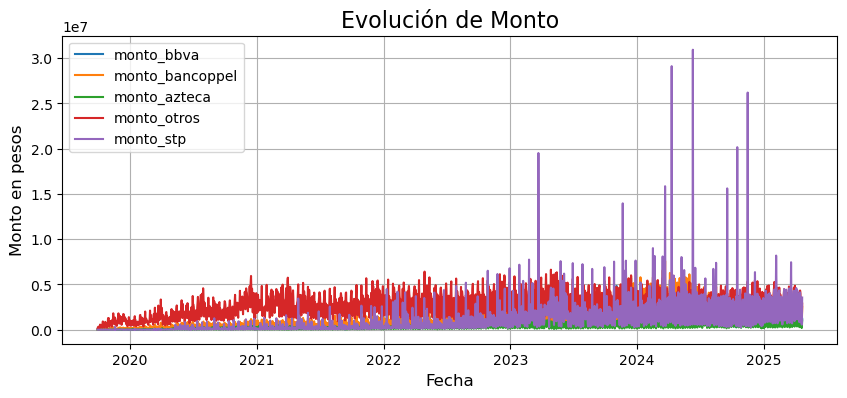

In [20]:
plot_evolucion(
    df_montos_procesados,
    columnas=['monto_bbva', 'monto_bancoppel', 'monto_azteca', 'monto_otros','monto_stp'],
    titulo="Evolución de Monto",
    ylabel="Monto en pesos"
)


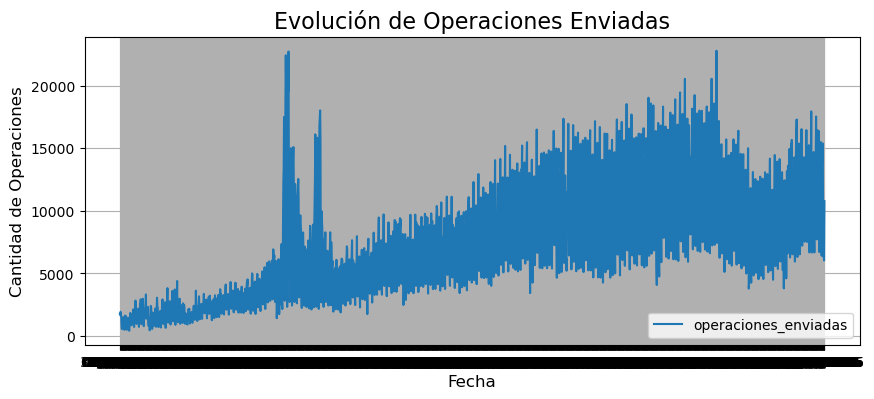

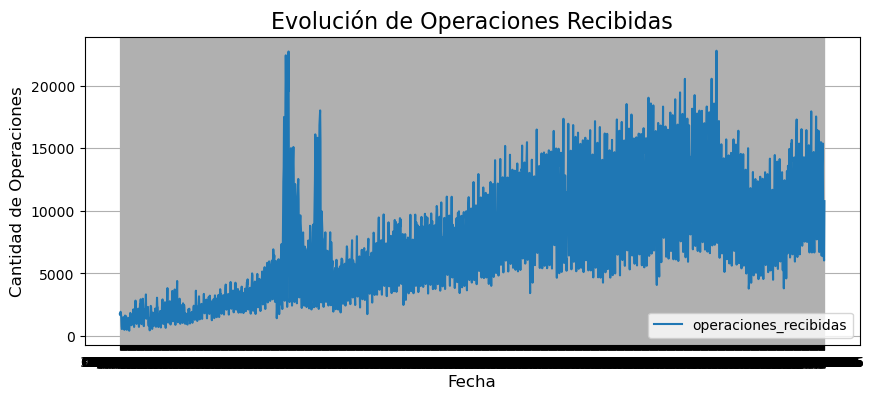

In [26]:
# Gráfica separada: Operaciones Enviadas
plot_evolucion(
    df_operaciones_realizadas,
    columnas=['operaciones_enviadas'],
    titulo="Evolución de Operaciones Enviadas",
    ylabel="Cantidad de Operaciones"
)

# Gráfica separada: Operaciones Recibidas
plot_evolucion(
    df_operaciones_realizadas,
    columnas=['operaciones_recibidas'],
    titulo="Evolución de Operaciones Recibidas",
    ylabel="Cantidad de Operaciones"
)


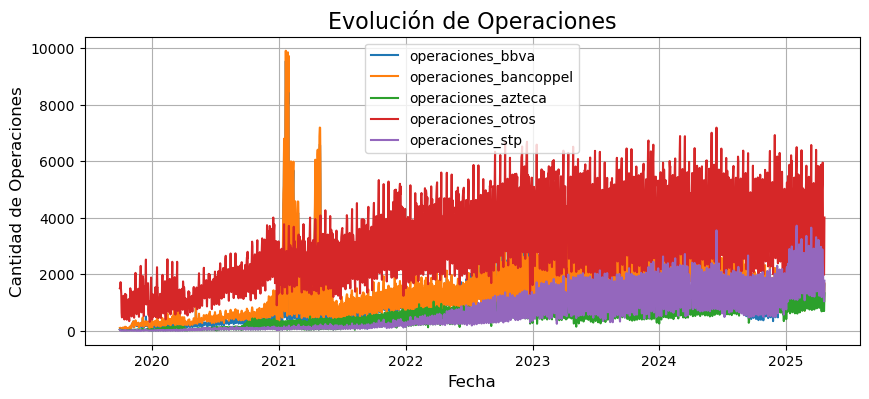

In [24]:
# Gráfica separada: Operaciones Enviadas
plot_evolucion(
    df_operaciones_realizadas,
    columnas=['operaciones_bbva', 'operaciones_bancoppel',
       'operaciones_azteca', 'operaciones_otros', 'operaciones_stp'],
    titulo="Evolución de Operaciones",
    ylabel="Cantidad de Operaciones"
)

# 📈 Interpretación de Gráficas de Evolución Temporal

---

## 1. Evolución de Dispositivos Enrolados (Android vs iOS)

**Qué observamos:**
- Crecimiento muy estable y sostenido en Android.
- Crecimiento de iOS también constante, pero siempre mucho más bajo que Android.
- Pequeños saltos negativos en ambos sistemas (posiblemente bajas de bancos como Banco Famsa en 2020).
- Después del 2023, la tasa de crecimiento parece desacelerar ligeramente.

**Ideas de análisis:**
- Analizar la proporción Android/iOS a lo largo del tiempo.
- Verificar si eventos como la baja de bancos afectaron la tendencia.

---

## 2. Evolución de Cuentas Validadas (Flujos Diarios)

**Qué observamos:**
- Picos positivos y negativos extremos.
- Flujos diarios normales son bajos, pero hay eventos de altísima volatilidad.

**Ideas de análisis:**
- Identificar días de alta variabilidad para entender si son cambios operativos o eventos especiales.
- Separar en días normales vs días anómalos.
- Aplicar smoothing o filtros para analizar la tendencia base.

---

## 3. Evolución de Cuentas con Transacciones (Pago vs Cobro)

**Qué observamos:**
- Crecimiento sostenido tanto en pagos como cobros.
- Siempre hay más cuentas que realizan pagos que cobros.
- Ligera reducción en la pendiente de crecimiento después de 2023.

**Ideas de análisis:**
- Analizar tasa de crecimiento anual.
- Verificar estacionalidades en pagos y cobros.
- Analizar efectos regulatorios o de mercado.

---

## 4. Evolución de Montos Procesados


### 4.1 Monto Enviado

**Qué observamos:**
- Tendencia creciente fuerte hasta 2024.
- Picos de altísima volatilidad.

**Ideas de análisis:**
- Revisar eventos asociados a picos de alto volumen (Hot Sale, Buen Fin, promociones).

### 4.2 Monto Recibido

**Qué observamos:**
- Evolución similar al monto enviado, pero requiere verlo separado para no "aplastar" la escala.
- En general sigue la misma tendencia que el monto enviado.

**Ideas de análisis:**
- Análisis de simetría entre montos enviados vs montos recibidos.

---

## 5. Evolución de Operaciones Realizadas

### 5.1 Operaciones Enviadas

**Qué observamos:**
- Crecimiento fuerte hasta 2023.
- Ligera disminución de operaciones en 2024-2025.

**Ideas de análisis:**
- Investigar la razón detrás de la caída: ¿saturación de mercado?, ¿reducción de actividad?

### 5.2 Operaciones Recibidas

**Qué observamos:**
- Evolución muy parecida a las operaciones enviadas.
- Mantiene alta correlación, como debería esperarse.

**Ideas de análisis:**
- Revisar si en algunos periodos la recepción es desproporcionada respecto al envío.

---


1. 📈 Análisis Dispositivos Android vs iOS

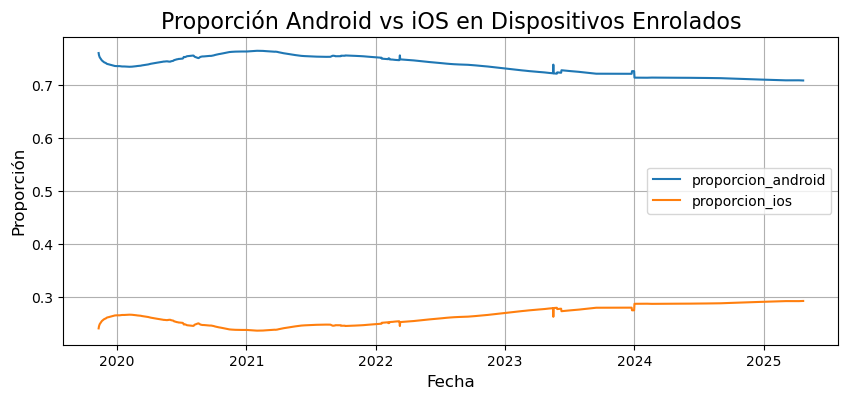

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_1705/1413177225.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_android_mensual = df_apps_moviles.resample('M', on='fecha').last()


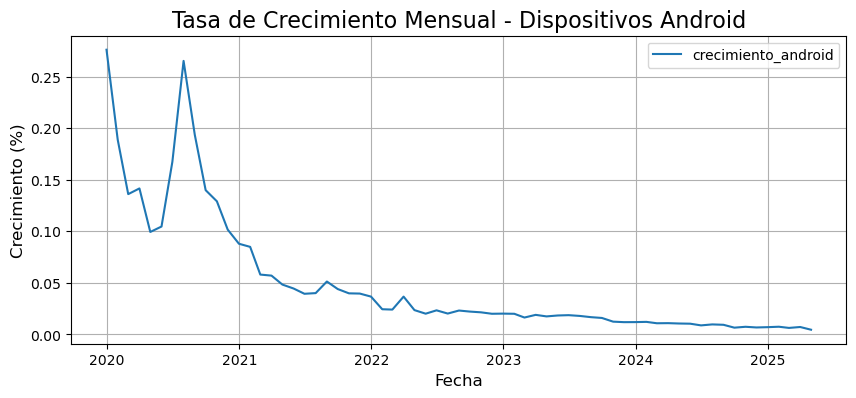

In [25]:
# Proporción de Android vs iOS
df_apps_moviles['proporcion_android'] = df_apps_moviles['dispositivos_android'] / (df_apps_moviles['dispositivos_android'] + df_apps_moviles['dispositivos_ios'])
df_apps_moviles['proporcion_ios'] = df_apps_moviles['dispositivos_ios'] / (df_apps_moviles['dispositivos_android'] + df_apps_moviles['dispositivos_ios'])

plot_evolucion(
    df_apps_moviles,
    columnas=['proporcion_android', 'proporcion_ios'],
    titulo="Proporción Android vs iOS en Dispositivos Enrolados",
    ylabel="Proporción"
)

# Tasa de crecimiento mensual (Android)
df_android_mensual = df_apps_moviles.resample('M', on='fecha').last()
df_android_mensual['crecimiento_android'] = df_android_mensual['dispositivos_android'].pct_change()

plot_evolucion(
    df_android_mensual,
    columnas=['crecimiento_android'],
    titulo="Tasa de Crecimiento Mensual - Dispositivos Android",
    ylabel="Crecimiento (%)"
)


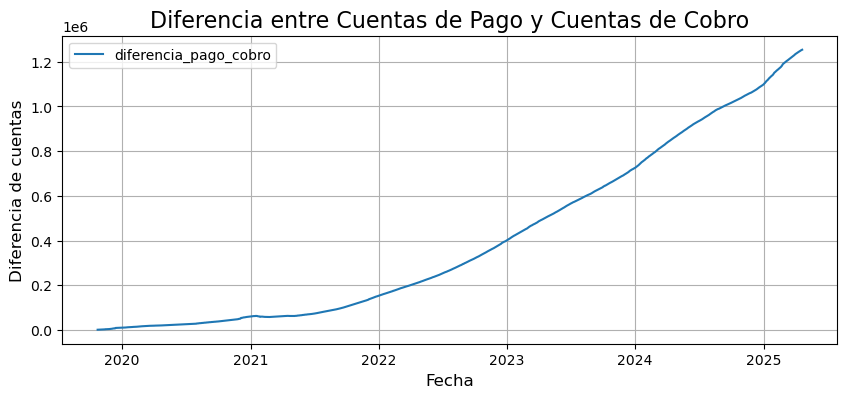

In [27]:
# Diferencia entre cuentas de pago y cuentas de cobro
df_cuentas_con_transacciones['diferencia_pago_cobro'] = df_cuentas_con_transacciones['cuentas_pago'] - df_cuentas_con_transacciones['cuentas_cobro']

plot_evolucion(
    df_cuentas_con_transacciones,
    columnas=['diferencia_pago_cobro'],
    titulo="Diferencia entre Cuentas de Pago y Cuentas de Cobro",
    ylabel="Diferencia de cuentas"
)


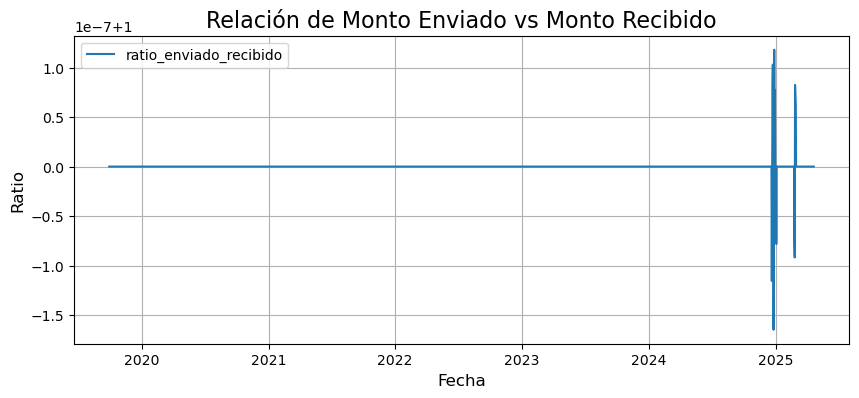

In [90]:
# Ratio monto enviado/recibido
df_montos_procesados['ratio_enviado_recibido'] = df_montos_procesados['monto_enviado'] / df_montos_procesados['monto_recibido']

plot_evolucion(
    df_montos_procesados,
    columnas=['ratio_enviado_recibido'],
    titulo="Relación de Monto Enviado vs Monto Recibido",
    ylabel="Ratio"
)


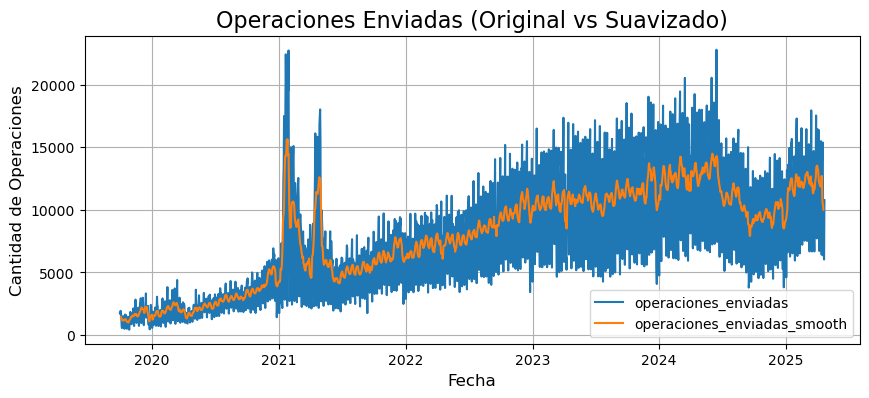

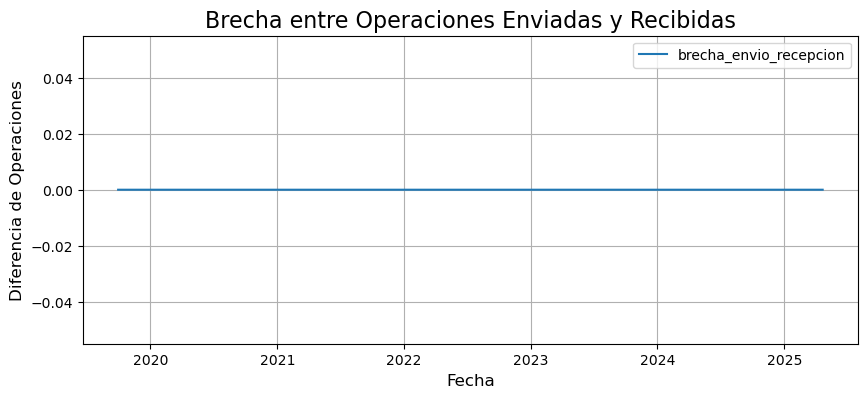

In [91]:
# Moving average (media móvil) operaciones enviadas
df_operaciones_realizadas['operaciones_enviadas_smooth'] = df_operaciones_realizadas['operaciones_enviadas'].rolling(window=7, center=True).mean()

plot_evolucion(
    df_operaciones_realizadas,
    columnas=['operaciones_enviadas', 'operaciones_enviadas_smooth'],
    titulo="Operaciones Enviadas (Original vs Suavizado)",
    ylabel="Cantidad de Operaciones"
)

# Brecha entre operaciones enviadas y recibidas
df_operaciones_realizadas['brecha_envio_recepcion'] = df_operaciones_realizadas['operaciones_enviadas'] - df_operaciones_realizadas['operaciones_recibidas']

plot_evolucion(
    df_operaciones_realizadas,
    columnas=['brecha_envio_recepcion'],
    titulo="Brecha entre Operaciones Enviadas y Recibidas",
    ylabel="Diferencia de Operaciones"
)


In [92]:
import pandas as pd

class DataFrameValidator:
    """
    Clase de validaciones automáticas para DataFrames de CoDi.
    """

    @staticmethod
    def validar_fechas_completas(df, start_date=None, end_date=None):
        """
        Valida que las fechas en el DataFrame sean continuas (diarias).
        """
        fechas = pd.date_range(start=start_date or df['fecha'].min(), end=end_date or df['fecha'].max(), freq='D')
        fechas_faltantes = fechas.difference(df['fecha'])
        
        if len(fechas_faltantes) == 0:
            print("✅ Fechas completas. No faltan días.")
        else:
            print(f"❌ Faltan {len(fechas_faltantes)} fechas:")
            print(fechas_faltantes)
        
        return fechas_faltantes

    @staticmethod
    def validar_acumulado_creciente(df, columna):
        """
        Valida que los datos de una columna acumulativa no decrezcan.
        """
        diferencias = df[columna].diff().dropna()
        decrecimientos = diferencias[diferencias < 0]
        
        if decrecimientos.empty:
            print(f"✅ {columna}: No hay decrecimientos, acumulado correcto.")
        else:
            print(f"❌ {columna}: Se encontraron {decrecimientos.count()} decrecimientos.")
            display(decrecimientos)
        
        return decrecimientos

    @staticmethod
    def validar_valores_negativos(df, columnas):
        """
        Valida que en las columnas especificadas no existan valores negativos.
        """
        negativos = {}
        
        for col in columnas:
            negativos_columna = df[df[col] < 0]
            if not negativos_columna.empty:
                print(f"❌ {col}: Se encontraron valores negativos.")
                negativos[col] = negativos_columna
            else:
                print(f"✅ {col}: No se encontraron valores negativos.")
        
        return negativos


In [93]:
DataFrameValidator.validar_fechas_completas(df_apps_moviles)
DataFrameValidator.validar_fechas_completas(df_cuentas_validadas)
DataFrameValidator.validar_fechas_completas(df_cuentas_con_transacciones)
DataFrameValidator.validar_fechas_completas(df_montos_procesados)
DataFrameValidator.validar_fechas_completas(df_operaciones_realizadas)

❌ Faltan 9 fechas:
DatetimeIndex(['2019-11-02', '2019-11-03', '2019-11-04', '2019-11-05',
               '2019-11-06', '2019-11-07', '2019-11-08', '2019-11-09',
               '2019-11-10'],
              dtype='datetime64[ns]', freq='D')
❌ Faltan 5 fechas:
DatetimeIndex(['2023-09-05', '2023-09-06', '2023-09-07', '2023-09-08',
               '2023-09-09'],
              dtype='datetime64[ns]', freq='D')
✅ Fechas completas. No faltan días.
✅ Fechas completas. No faltan días.
✅ Fechas completas. No faltan días.


DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [94]:
DataFrameValidator.validar_acumulado_creciente(df_apps_moviles, 'dispositivos_android')
DataFrameValidator.validar_acumulado_creciente(df_apps_moviles, 'dispositivos_ios')
DataFrameValidator.validar_acumulado_creciente(df_cuentas_con_transacciones, 'cuentas_pago')
DataFrameValidator.validar_acumulado_creciente(df_cuentas_con_transacciones, 'cuentas_cobro')


❌ dispositivos_android: Se encontraron 9 decrecimientos.


233      -17719.0
669       -8188.0
697       -7753.0
800      -97811.0
819     -195273.0
851    -1789608.0
908       -1925.0
921      -28586.0
1046      -7302.0
Name: dispositivos_android, dtype: float64

❌ dispositivos_ios: Se encontraron 11 decrecimientos.


233      -6213.0
685     -12916.0
697     -12278.0
819    -100697.0
851    -743856.0
921      -6728.0
1046     -3393.0
1284   -515958.0
1295    -76539.0
1307   -149321.0
1506   -178511.0
Name: dispositivos_ios, dtype: float64

✅ cuentas_pago: No hay decrecimientos, acumulado correcto.
✅ cuentas_cobro: No hay decrecimientos, acumulado correcto.


Series([], Name: cuentas_cobro, dtype: float64)

In [95]:
DataFrameValidator.validar_valores_negativos(
    df_montos_procesados,
    columnas=['monto_enviado', 'monto_recibido']
)

DataFrameValidator.validar_valores_negativos(
    df_operaciones_realizadas,
    columnas=['operaciones_enviadas', 'operaciones_recibidas']
)

DataFrameValidator.validar_valores_negativos(
    df_apps_moviles,
    columnas=['dispositivos_android', 'dispositivos_ios']
)


✅ monto_enviado: No se encontraron valores negativos.
✅ monto_recibido: No se encontraron valores negativos.
✅ operaciones_enviadas: No se encontraron valores negativos.
✅ operaciones_recibidas: No se encontraron valores negativos.
✅ dispositivos_android: No se encontraron valores negativos.
✅ dispositivos_ios: No se encontraron valores negativos.


{}

In [97]:
def rellenar_fechas(df, start_date=None, end_date=None):
    """
    Rellena fechas faltantes en un DataFrame sin inventar datos. Solo inserta fechas con NaN.
    """
    rango_fechas = pd.date_range(
        start=start_date or df['fecha'].min(),
        end=end_date or df['fecha'].max(),
        freq='D'
    )
    df_completo = df.set_index('fecha').reindex(rango_fechas).reset_index()
    df_completo = df_completo.rename(columns={'index': 'fecha'})
    return df_completo


In [98]:
# Solo aplicamos rellenado donde detectamos fechas faltantes
df_apps_moviles = rellenar_fechas(df_apps_moviles)
df_cuentas_con_transacciones = rellenar_fechas(df_cuentas_con_transacciones)

# Estos no necesitan relleno porque ya pasaron la validación:
# df_cuentas_validadas
# df_montos_procesados
# df_operaciones_realizadas


## Agregación Mensual

In [34]:
df_apps_moviles.columns

Index(['fecha', 'dispositivos_android', 'dispositivos_ios',
       'proporcion_android', 'proporcion_ios'],
      dtype='object')

In [35]:
df_apps_moviles.drop(columns=['proporcion_android', 'proporcion_ios'],inplace=True)

In [36]:
df_apps_moviles_mensual = agregar_mensual(df_apps_moviles, metodo='last')
df_apps_moviles_mensual.head(2)

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_1705/542001258.py:74: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df.resample('M').last()


,dispositivos_android,dispositivos_ios
fecha,,
2019-11-01,"1,029,428.00","357,359.00"
2019-12-01,"1,313,506.00","472,257.00"


In [37]:
df_cuentas_con_transacciones_mensual = agregar_mensual(df_cuentas_con_transacciones, metodo='last')
df_cuentas_con_transacciones_mensual.head(2)

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_1705/542001258.py:74: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df.resample('M').last()


,cuentas_pago,cuentas_cobro,diferencia_pago_cobro
fecha,,,
2019-10-01,"23,796.00","21,858.00","1,938.00"
2019-11-01,"48,431.00","43,143.00","5,288.00"


In [38]:
df_cuentas_validadas_mensual = agregar_mensual(df_cuentas_validadas[df_cuentas_validadas["fecha"]>='2020-09-01'], metodo='sum')
df_cuentas_validadas_mensual.head(2)

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_1705/542001258.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df.resample('M').sum()


,cuentas_bbva,cuentas_bancoppel,cuentas_azteca,cuentas_otros,cuentas_stp
fecha,,,,,
2020-09-01,"315,324.00","149,630.00","8,338.00","73,682.00","29,352.00"
2020-10-01,"389,448.00","100,991.00","9,623.00","63,455.00","34,417.00"


In [39]:
df_montos_procesados_mensual = agregar_mensual(df_montos_procesados, metodo='sum')
df_montos_procesados_mensual.head(2)

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_1705/542001258.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df.resample('M').sum()


,monto_bbva,monto_bancoppel,monto_azteca,monto_otros,monto_stp
fecha,,,,,
2019-09-01,"6,220.00","7,003.50","3,782.50","168,299.50",337.50
2019-10-01,"962,217.50","1,181,691.00","199,623.50","16,211,192.00","75,659.50"


In [40]:
df_operaciones_realizadas_mensual = agregar_mensual(df_operaciones_realizadas, metodo='sum')
df_operaciones_realizadas_mensual.head(2)

/var/folders/xv/_t61hd6d6fg3g4z034fpcpbr0000gn/T/ipykernel_1705/542001258.py:72: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensual = df.resample('M').sum()


,operaciones_bbva,operaciones_bancoppel,operaciones_azteca,operaciones_otros,operaciones_stp
fecha,,,,,
2019-09-01,50.50,95.50,38.00,"1,502.50",31.50
2019-10-01,"2,320.50","2,876.50",571.00,"31,104.00",250.50


## Unión de Datos y Creación de nuevas variables

In [41]:
df_merged = df_apps_moviles_mensual.merge(df_cuentas_con_transacciones_mensual, on="fecha", how="inner")
df_merged = df_merged.merge(df_cuentas_validadas_mensual, on="fecha", how="inner")
df_merged = df_merged.merge(df_montos_procesados_mensual, on="fecha", how="inner")
df_merged = df_merged.merge(df_operaciones_realizadas_mensual, on="fecha", how="inner")

In [46]:
df_merged.reset_index().to_csv("./data/clean_data.csv",index=False)

In [216]:
def crear_variables_derivadas(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crea nuevas variables derivadas a partir del DataFrame df_merge:
    - tasa_activacion = cuentas_pago / cuentas_validadas_totales
    - operaciones_por_cuenta_activa = operaciones / cuentas_pago
    - monto_promedio_por_operacion = monto / operaciones
    Aplica por banco (bbva, bancoppel, etc.) y también algunas variables globales.
    """
    df = df.copy()

    # Tasa de activación total
    df["tasa_activacion_total"] = df["cuentas_pago"] / (df["cuentas_bbva"] + df["cuentas_bancoppel"] + df["cuentas_azteca"] + df["cuentas_otros"] + df["cuentas_stp"])

    # Por banco
    bancos = ["bbva", "bancoppel", "azteca", "otros", "stp"]
    for banco in bancos:
        # Operaciones por cuenta activa
        df[f"ops_por_cuenta_{banco}"] = df[f"operaciones_{banco}"] / df[f"cuentas_{banco}"]

        # Monto promedio por operación
        df[f"monto_por_operacion_{banco}"] = df[f"monto_{banco}"] / df[f"operaciones_{banco}"]

    # Dispositivos totales
    df["dispositivos_totales"] = df["dispositivos_android"] + df["dispositivos_ios"]
    df["proporcion_android"] = df["dispositivos_android"] / df["dispositivos_totales"]

    return df


In [220]:
def agregar_deltas_y_ratios(df: pd.DataFrame) -> pd.DataFrame:
    """
    Agrega al DataFrame:
    - Deltas proporcionales (pct_change) para variables no target
    - Ratios de dispositivos por cuenta
    - Proporción de cuentas de pago vs cobro
    """
    df = df.copy()
    
    # Cambios proporcionales (evitamos target como montos y operaciones)
    columnas_deltas = ["cuentas_pago", "cuentas_cobro", "cuentas_bbva", "cuentas_bancoppel",
                       "cuentas_azteca", "cuentas_otros", "cuentas_stp", 
                       "dispositivos_android", "dispositivos_ios"]

    for col in columnas_deltas:
        if col in df.columns:
            df[f"delta_{col}"] = df[col].pct_change()

    # Total de dispositivos y cuentas
    df["dispositivos_totales"] = df["dispositivos_android"] + df["dispositivos_ios"]
    df["cuentas_total"] = df[["cuentas_bbva", "cuentas_bancoppel", "cuentas_azteca", "cuentas_otros", "cuentas_stp"]].sum(axis=1)

    # Ratio dispositivos por cuenta activa
    df["dispositivos_por_cuenta_pago"] = df["dispositivos_totales"] / df["cuentas_pago"]
    df["dispositivos_por_cuenta_total"] = df["dispositivos_totales"] / df["cuentas_total"]

    # Proporción cuentas de pago respecto al total de cuentas activas
    df["cuentas_pago_vs_total"] = df["cuentas_pago"] / (df["cuentas_pago"] + df["cuentas_cobro"])

    return df


In [221]:
data = crear_variables_derivadas(df_merged)
data = agregar_deltas_y_ratios(data)

In [236]:
def seleccionar_features(df: pd.DataFrame, targets: list) -> list:
    """
    Dada una lista de variables objetivo (targets), devuelve una lista de columnas recomendadas como features:
    - Excluye columnas que sean los targets explícitos
    - Excluye columnas derivadas del target (por ejemplo, 'monto_por_operacion_*' si 'monto' está en target)
    - Excluye columnas que contienen 'total' o 'totales' (excepto 'tasa_activacion_total')
    - Retorna solo columnas numéricas que no estén directamente relacionadas con los targets
    """
    columnas = df.columns
    features = []

    for col in columnas:
        # Excluir si es un target directo
        if any(target in col for target in targets):
            continue
        # Excluir si es una derivación típica del target
        if any("por_operacion" in col or "por_cuenta" in col for target in targets):
            continue
        # Excluir si contiene "total" o "totales", excepto tasa_activacion_total
        if ("total" in col.lower() or "totales" in col.lower()) and col != "tasa_activacion_total":
            continue
        # Incluir solo columnas numéricas válidas
        if col != "fecha" and pd.api.types.is_numeric_dtype(df[col]):
            features.append(col)

    return features


In [237]:
# Para un modelo que prediga montos por banco:
features_monto = seleccionar_features(data, targets=["monto"])

# Para operaciones:
features_operaciones = seleccionar_features(data, targets=["operaciones"])

# Para cuentas:
features_cuentas = seleccionar_features(data, targets=["cuentas"])


In [238]:
features_monto

['dispositivos_android',
 'dispositivos_ios',
 'cuentas_pago',
 'cuentas_cobro',
 'cuentas_bbva',
 'cuentas_bancoppel',
 'cuentas_azteca',
 'cuentas_otros',
 'cuentas_stp',
 'operaciones_bbva',
 'operaciones_bancoppel',
 'operaciones_azteca',
 'operaciones_otros',
 'operaciones_stp',
 'tasa_activacion_total',
 'proporcion_android',
 'delta_cuentas_pago',
 'delta_cuentas_cobro',
 'delta_cuentas_bbva',
 'delta_cuentas_bancoppel',
 'delta_cuentas_azteca',
 'delta_cuentas_otros',
 'delta_cuentas_stp',
 'delta_dispositivos_android',
 'delta_dispositivos_ios']

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def diagnostico_multicolinealidad(df: pd.DataFrame, features: list):
    """
    Genera:
    - Matriz de correlación visual (heatmap)
    - VIF (Variance Inflation Factor) para las variables seleccionadas
    """
    df_subset = df[features].dropna().copy()

    # 1. Correlation heatmap
    plt.figure(figsize=(12, 10))
    corr = df_subset.corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
    plt.title("Matriz de correlación")
    plt.show()

    # 2. VIF calculation
    vif_data = pd.DataFrame()
    vif_data["variable"] = df_subset.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df_subset.values, i) for i in range(df_subset.shape[1])
    ]

    return vif_data


In [235]:
data.columns

Index(['dispositivos_android', 'dispositivos_ios', 'cuentas_pago',
       'cuentas_cobro', 'cuentas_bbva', 'cuentas_bancoppel', 'cuentas_azteca',
       'cuentas_otros', 'cuentas_stp', 'monto_bbva', 'monto_bancoppel',
       'monto_azteca', 'monto_otros', 'monto_stp', 'operaciones_bbva',
       'operaciones_bancoppel', 'operaciones_azteca', 'operaciones_otros',
       'operaciones_stp', 'tasa_activacion_total', 'ops_por_cuenta_bbva',
       'monto_por_operacion_bbva', 'ops_por_cuenta_bancoppel',
       'monto_por_operacion_bancoppel', 'ops_por_cuenta_azteca',
       'monto_por_operacion_azteca', 'ops_por_cuenta_otros',
       'monto_por_operacion_otros', 'ops_por_cuenta_stp',
       'monto_por_operacion_stp', 'dispositivos_totales', 'proporcion_android',
       'delta_cuentas_pago', 'delta_cuentas_cobro', 'delta_cuentas_bbva',
       'delta_cuentas_bancoppel', 'delta_cuentas_azteca',
       'delta_cuentas_otros', 'delta_cuentas_stp',
       'delta_dispositivos_android', 'delta_disposit

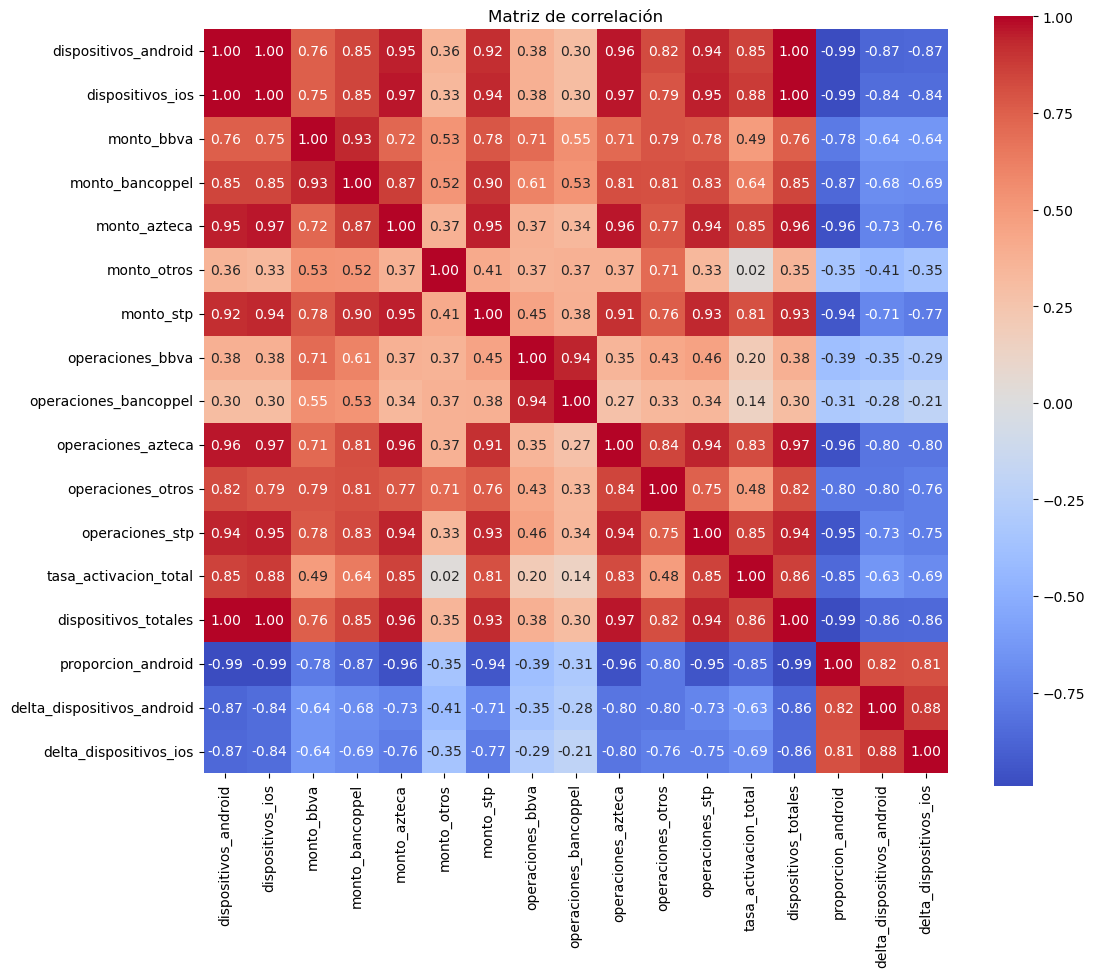

/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variable,VIF
0,dispositivos_android,inf
1,dispositivos_ios,inf
2,monto_bbva,273.17
3,monto_bancoppel,530.60
4,monto_azteca,788.27
5,monto_otros,475.84
6,monto_stp,105.02
7,operaciones_bbva,678.90
8,operaciones_bancoppel,681.99
9,operaciones_azteca,591.46


In [233]:
diagnostico_multicolinealidad(data, features_cuentas)

In [240]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import log
import statsmodels.api as sm

def ajustar_glm_gamma_por_banco(df: pd.DataFrame, bancos: list, target_base: str = "monto") -> dict:
    """
    Ajusta un GLM (Gamma con enlace log) para cada banco en la lista.
    Usa automáticamente las features seleccionadas sin leakage.

    Retorna:
    - Diccionario con resultados del modelo por banco.
    """
    resultados_modelos = {}

    for banco in bancos:
        target_col = f"{target_base}_{banco}"
        if target_col not in df.columns:
            continue

        # Seleccionar features excluyendo todas las relacionadas al target
        features = seleccionar_features(df, targets=[target_base])
        df_model = df[["fecha", target_col] + features].dropna()

        # Definir X y y
        X = df_model[features]
        X = sm.add_constant(X)
        y = df_model[target_col]

        # Ajustar modelo
        modelo = GLM(y, X, family=Gamma(link=log()))
        resultado = modelo.fit()

        resultados_modelos[banco] = resultado

    return resultados_modelos


In [246]:
data_model = data.reset_index().copy()

In [248]:
resultados = ajustar_glm_gamma_por_banco(data_model, bancos=["bbva", "bancoppel", "azteca", "otros", "stp"])


/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead

In [249]:
resultados

{'bbva': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x323472dd0>,
 'bancoppel': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x3231cfa50>,
 'azteca': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x32a804d10>,
 'otros': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x32a724550>,
 'stp': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper at 0x32a73fe10>}

In [250]:
print(resultados["bbva"].summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:             monto_bbva   No. Observations:                   55
Model:                            GLM   Df Residuals:                       29
Model Family:                   Gamma   Df Model:                           25
Link Function:                    log   Scale:                       0.0062801
Method:                          IRLS   Log-Likelihood:                -874.18
Date:                Thu, 01 May 2025   Deviance:                      0.18287
Time:                        15:47:32   Pearson chi2:                    0.182
No. Iterations:                    10   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [251]:
resultados["bbva"].aic

np.float64(1800.3616867948642)

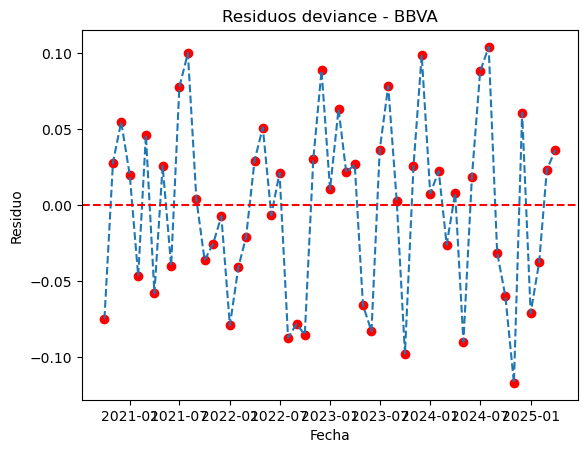

In [269]:
import matplotlib.pyplot as plt

residuos = resultados["bbva"].resid_deviance
plt.plot(data_model["fecha"].drop(0), residuos,'--')
plt.scatter(data_model["fecha"].drop(0), residuos, c='r')
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuos deviance - BBVA")
plt.xlabel("Fecha")
plt.ylabel("Residuo")
plt.show()


In [272]:
resultados["bbva"].fittedvalues

1     8,464,677.03
2     8,281,091.52
3     9,827,166.79
4     8,829,968.10
5     9,622,561.86
6     9,963,806.93
7    11,840,067.62
8    11,612,085.24
9    10,578,842.78
10   11,239,190.03
11   11,495,230.67
12   11,481,842.34
13   14,443,933.20
14   15,250,254.79
15   18,572,511.33
16   19,274,390.24
17   18,449,810.27
18   22,158,071.82
19   21,189,659.39
20   23,506,046.33
21   26,401,547.18
22   29,891,274.11
23   34,093,899.00
24   37,219,896.14
25   41,333,518.49
26   40,669,226.84
27   49,883,663.45
28   51,216,405.97
29   48,429,468.69
30   60,803,826.77
31   53,366,458.63
32   64,794,274.68
33   62,350,314.66
34   55,162,506.87
35   56,374,818.79
36   62,169,761.69
37   75,558,719.15
38   72,330,522.35
39   80,202,484.10
40   79,359,615.58
41   78,810,367.40
42   86,442,952.63
43   81,484,628.94
44   95,879,287.15
45   70,378,907.27
46   44,808,778.85
47   46,430,963.08
48   26,862,795.72
49   26,769,305.64
50   29,580,104.54
51   33,124,476.36
52   51,489,995.36
53   49,437,

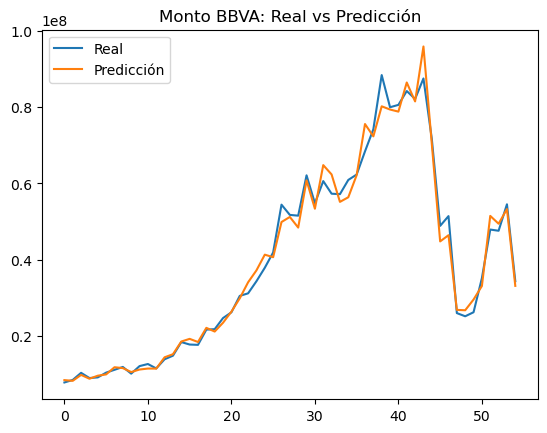

In [278]:
pred = resultados["bbva"].fittedvalues
datos = data_model.drop(0)
real = datos.loc[pred.index, "monto_bbva"]

plt.plot(real.values, label="Real")
plt.plot(pred.values, label="Predicción")
plt.title("Monto BBVA: Real vs Predicción")
plt.legend()
plt.show()


In [279]:
import numpy as np
import pandas as pd

def interpretar_coeficientes_glm(resultados_modelo, banco: str) -> pd.DataFrame:
    """
    Recibe el resultado de un modelo GLM (statsmodels) y devuelve una tabla interpretativa:
    - Coeficiente
    - Error estándar
    - p-valor
    - Exp(coef): efecto multiplicativo
    - Efecto % aproximado
    - Significancia (* si p < 0.05)
    """
    res = resultados_modelo[banco]
    coef = res.params
    std_err = res.bse
    pval = res.pvalues

    interpretacion = pd.DataFrame({
        "Coeficiente": coef,
        "Error estándar": std_err,
        "p-valor": pval,
        "Exp(Coef)": np.exp(coef),
        "Efecto % aprox.": (np.exp(coef) - 1) * 100,
        "Significativo": pval < 0.05
    })

    interpretacion["Signo"] = interpretacion["Coeficiente"].apply(lambda x: "+" if x > 0 else "-")
    interpretacion["Interpretación"] = interpretacion.apply(
        lambda row: (
            f"Aumenta Y en aproximadamente {row['Efecto % aprox.']:.1f}% por unidad extra de X"
            if row["Coeficiente"] > 0
            else f"Disminuye Y en aproximadamente {abs(row['Efecto % aprox.']):.1f}% por unidad extra de X"
        ), axis=1
    )

    return interpretacion.sort_values(by="Efecto % aprox.", ascending=False)


In [281]:
interpretacion_bbva = interpretar_coeficientes_glm(resultados, banco="bbva")
interpretacion_bbva

,Coeficiente,Error estándar,p-valor,Exp(Coef),Efecto % aprox.,Significativo,Signo,Interpretación
const,54.11,16.25,0.00,"315,699,034,673,039,573,778,432.00","31,569,903,467,303,957,646,278,656.00",True,+,Aumenta Y en aproximadamente 31569903467303957...
delta_dispositivos_android,6.73,3.95,0.09,840.84,"83,983.79",False,+,Aumenta Y en aproximadamente 83983.8% por unid...
delta_cuentas_pago,4.94,5.25,0.35,139.49,"13,849.01",False,+,Aumenta Y en aproximadamente 13849.0% por unid...
delta_cuentas_otros,0.07,0.11,0.52,1.07,7.30,False,+,Aumenta Y en aproximadamente 7.3% por unidad e...
delta_cuentas_azteca,0.06,0.08,0.50,1.06,5.93,False,+,Aumenta Y en aproximadamente 5.9% por unidad e...
operaciones_bbva,0.00,0.00,0.00,1.00,0.00,True,+,Aumenta Y en aproximadamente 0.0% por unidad e...
cuentas_bancoppel,0.00,0.00,0.01,1.00,0.00,True,+,Aumenta Y en aproximadamente 0.0% por unidad e...
operaciones_otros,0.00,0.00,0.08,1.00,0.00,False,+,Aumenta Y en aproximadamente 0.0% por unidad e...
operaciones_stp,0.00,0.00,0.85,1.00,0.00,False,+,Aumenta Y en aproximadamente 0.0% por unidad e...
dispositivos_android,0.00,0.00,0.00,1.00,0.00,True,+,Aumenta Y en aproximadamente 0.0% por unidad e...


In [282]:
fecha_corte = pd.to_datetime("2024-12-31")
df_train = data_model[data_model["fecha"] <= fecha_corte]
df_test = data_model[data_model["fecha"] > fecha_corte]


In [284]:
modelos = ajustar_glm_gamma_por_banco(df_train, bancos=["bbva", "bancoppel", "azteca", "otros", "stp"])


/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead

In [288]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

def flujo_validacion_temporal_glm(df: pd.DataFrame, bancos: list, target_base: str = "monto", fecha_corte: str = "2024-12-31"):
    """
    Ejecuta todo el flujo de validación temporal:
    - Split de datos en train y test basado en fecha
    - Ajuste de modelo GLM Gamma por banco en train
    - Predicción en test
    - Cálculo de métricas (MAE, MAPE)
    - Gráfico de real vs predicho

    Retorna:
    - Diccionario de métricas por banco
    """
    fecha_corte = pd.to_datetime(fecha_corte)
    df_train = df[df["fecha"] <= fecha_corte].copy()
    df_test = df[df["fecha"] > fecha_corte].copy()

    resultados_modelos = ajustar_glm_gamma_por_banco(df_train, bancos, target_base)
    metricas = {}

    for banco in bancos:
        target_col = f"{target_base}_{banco}"
        if target_col not in df.columns:
            continue

        # Seleccionar features válidas
        features = seleccionar_features(df, targets=[target_base])
        df_test_clean = df_test[["fecha", target_col] + features].dropna()
        if df_test_clean.empty:
            continue

        X_test = sm.add_constant(df_test_clean[features])
        y_real = df_test_clean[target_col]

        modelo = resultados_modelos.get(banco)
        if modelo is None:
            continue

        y_pred = modelo.predict(X_test)

        # Métricas
        mae = mean_absolute_error(y_real, y_pred)
        mape = mean_absolute_percentage_error(y_real, y_pred) * 100
        metricas[banco] = {"MAE": mae, "MAPE": mape}

        # Gráfico
        plt.figure(figsize=(8, 4))
        plt.plot(df_test_clean["fecha"], y_real, label="Real", marker="o")
        plt.plot(df_test_clean["fecha"], y_pred, label="Predicción", marker="x")
        plt.title(f"Validación temporal - {banco.upper()}")
        plt.xlabel("Fecha")
        plt.ylabel("Monto")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return metricas


In [291]:
def flujo_validacion_temporal_glm_con_entrenamiento(df: pd.DataFrame, bancos: list, target_base: str = "monto", fecha_corte: str = "2024-12-31"):
    """
    Igual que flujo_validacion_temporal_glm, pero además:
    - Incluye gráfico extendido con entrenamiento + validación
    """
    fecha_corte = pd.to_datetime(fecha_corte)
    df_train = df[df["fecha"] <= fecha_corte].copy()
    df_test = df[df["fecha"] > fecha_corte].copy()

    resultados_modelos = ajustar_glm_gamma_por_banco(df_train, bancos, target_base)
    metricas = {}

    for banco in bancos:
        target_col = f"{target_base}_{banco}"
        if target_col not in df.columns:
            continue

        # Seleccionar features válidas
        features = seleccionar_features(df, targets=[target_base])

        # Entrenamiento
        df_train_clean = df_train[["fecha", target_col] + features].dropna()
        X_train = sm.add_constant(df_train_clean[features])
        y_train = df_train_clean[target_col]

        # Test
        df_test_clean = df_test[["fecha", target_col] + features].dropna()
        if df_test_clean.empty:
            continue
        X_test = sm.add_constant(df_test_clean[features])
        y_test = df_test_clean[target_col]

        modelo = resultados_modelos.get(banco)
        if modelo is None:
            continue

        y_pred_train = modelo.predict(X_train)
        y_pred_test = modelo.predict(X_test)

        # Métricas de validación
        mae = mean_absolute_error(y_test, y_pred_test)
        mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
        metricas[banco] = {"MAE": mae, "MAPE": mape}

        # Gráfico comparativo extendido
        plt.figure(figsize=(10, 5))
        plt.plot(df_train_clean["fecha"], y_train, label="Real (entrenamiento)", linestyle="solid")
        plt.plot(df_train_clean["fecha"], y_pred_train, label="Predicho (entrenamiento)", linestyle="dashed")
        plt.plot(df_test_clean["fecha"], y_test, label="Real (validación)", linestyle="solid", color="black", marker="o")
        plt.plot(df_test_clean["fecha"], y_pred_test, label="Predicho (validación)", linestyle="dashed", color="red", marker="x")
        plt.axvline(fecha_corte, color="gray", linestyle="--", label="Corte entrenamiento")
        plt.title(f"Entrenamiento + Validación - {banco.upper()}")
        plt.xlabel("Fecha")
        plt.ylabel("Monto")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return metricas


/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead

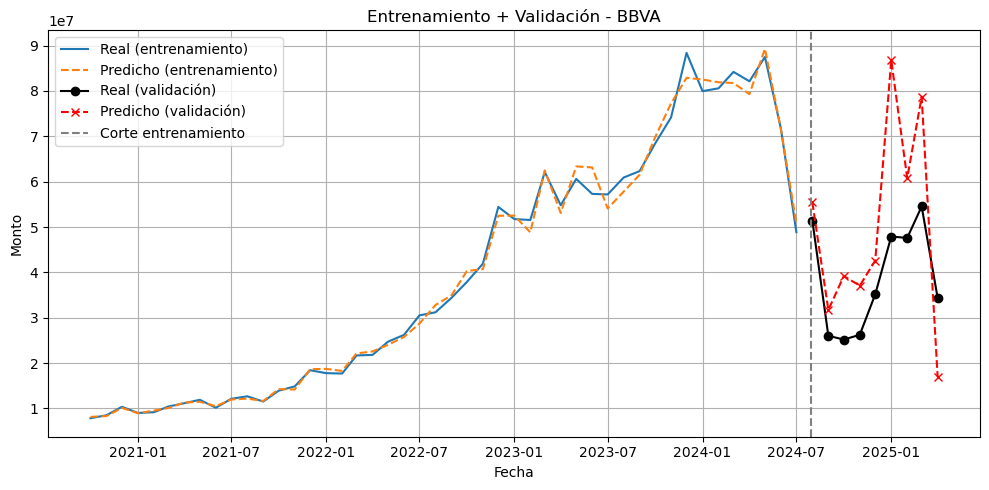

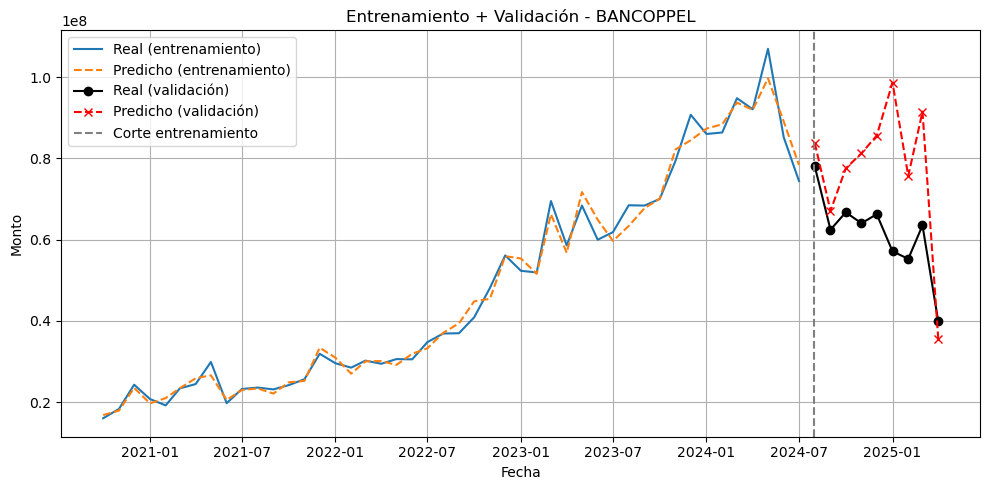

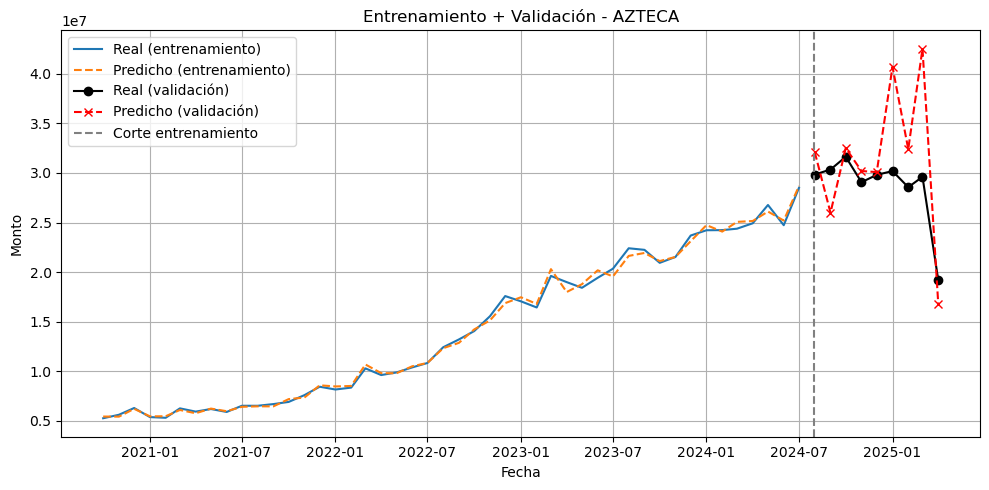

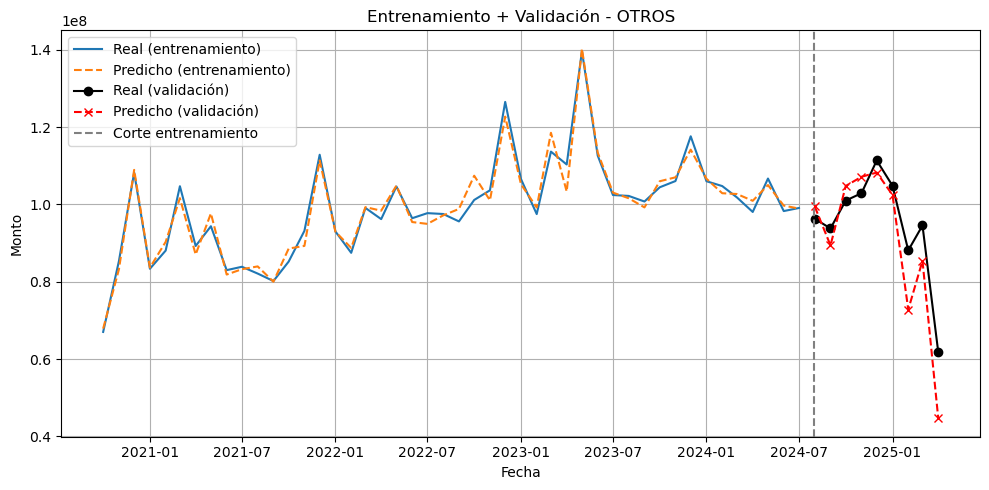

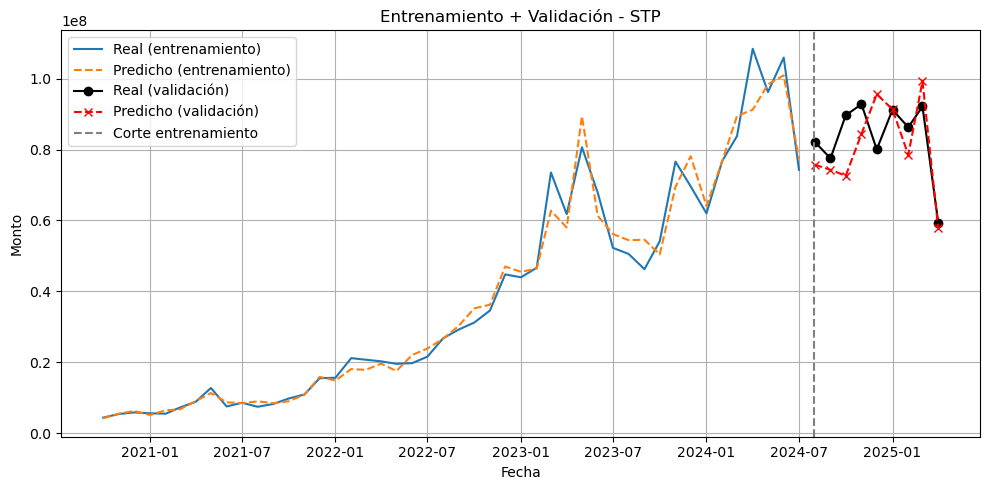

In [294]:
metricas = flujo_validacion_temporal_glm_con_entrenamiento(
    df=data_model,
    bancos=["bbva", "bancoppel", "azteca", "otros", "stp"],
    target_base="monto",
    fecha_corte="2024-07-30"
)


In [295]:
def preparar_dataframe_jerarquico(df: pd.DataFrame, bancos: list) -> pd.DataFrame:
    """
    Prepara un DataFrame largo (tidy) para modelado jerárquico.
    Estructura final: una fila por banco y fecha.
    Variables: monto, cuentas, operaciones, dispositivos.

    Retorna:
    - DataFrame con columnas: fecha, banco, monto, cuentas, operaciones, dispositivos_android, dispositivos_ios
    """
    registros = []

    for banco in bancos:
        if all(f in df.columns for f in [f"monto_{banco}", f"cuentas_{banco}", f"operaciones_{banco}"]):
            temp_df = pd.DataFrame({
                "fecha": df["fecha"],
                "banco": banco,
                "monto": df[f"monto_{banco}"],
                "cuentas": df[f"cuentas_{banco}"],
                "operaciones": df[f"operaciones_{banco}"],
                "dispositivos_android": df["dispositivos_android"],
                "dispositivos_ios": df["dispositivos_ios"]
            })
            registros.append(temp_df)

    df_largo = pd.concat(registros, ignore_index=True)
    return df_largo.dropna()  # quitar cualquier fila incompleta antes de modelar


In [296]:
bancos = ["bbva", "bancoppel", "azteca", "otros", "stp"]

In [298]:
df_largo = preparar_dataframe_jerarquico(data_model, bancos)

In [ ]:
df_largo

In [304]:
import bambi as bmb

In [308]:
import numpy as np

def escalar_predictores_log(df: pd.DataFrame, columnas: list) -> pd.DataFrame:
    df = df.copy()
    for col in columnas:
        # Para evitar log(0) o valores negativos, sumamos 1
        df[f"log_{col}"] = np.log(df[col] + 1)
    return df


In [317]:
df_largo_log = escalar_predictores_log(df_largo, columnas = ['monto', 'cuentas', 'operaciones','dispositivos_android', 'dispositivos_ios'])
df_largo_log["log_cuentas"] = np.log(df_largo_log["cuentas"].clip(lower=0) + 1)

/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [318]:
modelo = bmb.Model(
    "monto ~ log_cuentas + log_operaciones + log_dispositivos_android + log_dispositivos_ios + (1 | banco)",
    df_largo_log,
    family="gamma"
)


In [329]:
import bambi as bmb

def ajustar_modelo_jerarquico(df_largo: pd.DataFrame):
    """
    Ajusta un modelo jerárquico bayesiano con distribución Gamma:
    monto ~ cuentas + operaciones + dispositivos_android + dispositivos_ios + (1 | banco)
    """
    # Modelo con intercepto aleatorio por banco
    modelo = bmb.Model(
        "monto ~ log_cuentas + log_operaciones + log_dispositivos_android + log_dispositivos_ios + (1 | banco)",
        df_largo_log,
        family="gamma"
    )
    # Ajustar el modelo con muestreo MCMC
    resultado = modelo.fit(draws=1000, chains=2, progressbar=False)

    return modelo, resultado


In [334]:
df_largo_log["monto"] = df_largo_log["monto"]/1000000

In [335]:
df_largo_log

,fecha,banco,monto,cuentas,operaciones,dispositivos_android,dispositivos_ios,log_monto,log_cuentas,log_operaciones,log_dispositivos_android,log_dispositivos_ios
0,2020-09-01,bbva,7.08,"315,324.00","10,284.00","4,938,701.00","1,597,143.00",15.77,12.66,9.24,15.41,14.28
1,2020-10-01,bbva,7.85,"389,448.00","10,990.00","5,575,963.00","1,757,739.00",15.88,12.87,9.30,15.53,14.38
2,2020-11-01,bbva,8.51,"324,465.00","11,839.50","6,142,203.00","1,908,697.00",15.96,12.69,9.38,15.63,14.46
3,2020-12-01,bbva,10.38,"329,412.00","21,608.00","6,682,017.00","2,073,589.00",16.15,12.71,9.98,15.71,14.54
4,2021-01-01,bbva,9.01,"333,566.00","108,665.50","7,248,995.00","2,232,731.00",16.01,12.72,11.60,15.80,14.62
...,...,...,...,...,...,...,...,...,...,...,...,...
275,2024-12-01,stp,80.03,"39,629.00","44,851.50","21,087,465.00","8,613,792.00",18.20,10.59,10.71,16.86,15.97
276,2025-01-01,stp,91.22,"43,350.00","68,680.00","21,244,502.00","8,707,062.00",18.33,10.68,11.14,16.87,15.98
277,2025-02-01,stp,86.29,"36,867.00","63,449.50","21,378,314.00","8,787,420.00",18.27,10.52,11.06,16.88,15.99
278,2025-03-01,stp,92.15,"39,464.00","71,601.00","21,531,889.00","8,841,101.00",18.34,10.58,11.18,16.89,15.99


In [337]:
df_largo_log["monto"] = df_largo_log["monto"].clip(lower=1e-3)

In [338]:
df_largo_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   fecha                     280 non-null    datetime64[ns]
 1   banco                     280 non-null    object        
 2   monto                     280 non-null    float64       
 3   cuentas                   280 non-null    float64       
 4   operaciones               280 non-null    float64       
 5   dispositivos_android      280 non-null    float64       
 6   dispositivos_ios          280 non-null    float64       
 7   log_monto                 280 non-null    float64       
 8   log_cuentas               280 non-null    float64       
 9   log_operaciones           280 non-null    float64       
 10  log_dispositivos_android  280 non-null    float64       
 11  log_dispositivos_ios      280 non-null    float64       
dtypes: datetime64[ns](1), 

In [339]:
vars_usadas = [
    "monto", "log_cuentas", "log_operaciones", "log_dispositivos_android", "log_dispositivos_ios", "banco"
]
df_model = df_largo_log[vars_usadas].dropna()


In [341]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   monto                     280 non-null    float64
 1   log_cuentas               280 non-null    float64
 2   log_operaciones           280 non-null    float64
 3   log_dispositivos_android  280 non-null    float64
 4   log_dispositivos_ios      280 non-null    float64
 5   banco                     280 non-null    object 
dtypes: float64(5), object(1)
memory usage: 13.3+ KB


In [344]:
modelo = bmb.Model(
    "log_monto ~ log_cuentas + log_operaciones + log_dispositivos_android + log_dispositivos_ios + (1 | banco)",
    df_largo_log.dropna(),
    family="gaussian"
)
resultado = modelo.fit(draws=1000, chains=2, init="adapt_diag", tune=1000)


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, log_cuentas, log_operaciones, log_dispositivos_android, log_dispositivos_ios, 1|banco_sigma, 1|banco_offset]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [345]:
modelo = bmb.Model(
    "log_monto ~ log_cuentas + log_operaciones + log_dispositivos_android + log_dispositivos_ios + (1 | banco)",
    df_largo_log.dropna(),
    family="gaussian"
)
resultado = modelo.fit(draws=1000, chains=2, init="adapt_diag", tune=1000)


Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, log_cuentas, log_operaciones, log_dispositivos_android, log_dispositivos_ios, 1|banco_sigma, 1|banco_offset]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [346]:
resultado.posterior["1|banco"].mean(dim=["chain", "draw"])


<xarray.DataArray '1|banco' (banco__factor_dim: 5)> Size: 40B
array([-0.52985256,  0.00416693, -0.28406355,  0.33215372,  0.35110521])
Coordinates:
  * banco__factor_dim  (banco__factor_dim) <U9 180B 'azteca' ... 'stp'

In [348]:
def interpretar_resultados_bambi(modelo, resultado, bancos: list) -> pd.DataFrame:
    """
    Extrae los efectos fijos y aleatorios de un modelo Bambi (Bayesiano jerárquico)
    e interpreta sus efectos como porcentajes.

    Retorna:
    - Tabla con coeficientes globales (fijos)
    - Tabla con efectos aleatorios por banco (intercepto)
    """
    import numpy as np

    # Coeficientes globales (fijos)
    efectos_fijos = resultado.posterior.mean(dim=["chain", "draw"]).to_dataframe().reset_index()
    efectos_fijos = efectos_fijos[efectos_fijos["variable"] != "1|banco"]
    efectos_fijos["exp(coef)"] = np.exp(efectos_fijos["value"])
    efectos_fijos["efecto_%"] = (efectos_fijos["exp(coef)"] - 1) * 100
    efectos_fijos["interpretación"] = efectos_fijos.apply(
        lambda row: f"↑ {row['efecto_%']:.1f}% en monto por +1% en {row['variable'].replace('log_', '')}"
        if row["value"] > 0 else
        f"↓ {abs(row['efecto_%']):.1f}% en monto por +1% en {row['variable'].replace('log_', '')}",
        axis=1
    )

    # Efectos aleatorios (interceptos por banco)
    efectos_banco = resultado.posterior["1|banco"].mean(dim=["chain", "draw"]).to_series().reset_index()
    efectos_banco.columns = ["grupo", "banco", "intercepto"]
    efectos_banco = efectos_banco[efectos_banco["banco"].isin(bancos)]
    efectos_banco["exp(intercepto)"] = np.exp(efectos_banco["intercepto"])
    efectos_banco["interpretación"] = efectos_banco.apply(
        lambda row: f"{row['banco']}: efecto base multiplicativo ≈ {row['exp(intercepto)']:.2f}x", axis=1
    )

    return efectos_fijos[["variable", "value", "efecto_%", "interpretación"]], efectos_banco[["banco", "intercepto", "exp(intercepto)", "interpretación"]]


In [350]:
def ajustar_y_interpretar_modelo_gaussiano(df_largo_log, bancos):
    """
    Ajusta un modelo jerárquico gaussiano sobre log_monto y devuelve la interpretación
    de efectos fijos y aleatorios.
    """
    import bambi as bmb
    import numpy as np

    # Preparar datos
    df_model = df_largo_log.copy()
    df_model["monto"] = df_model["monto"].clip(lower=1e-3)
    df_model = df_model.dropna(subset=[
        "monto", "log_monto", "log_cuentas", "log_operaciones", "log_dispositivos_android", "log_dispositivos_ios"
    ])

    # Ajustar modelo
    modelo = bmb.Model(
        "log_monto ~ log_cuentas + log_operaciones + log_dispositivos_android + log_dispositivos_ios + (1 | banco)",
        df_model,
        family="gaussian"
    )
    resultado = modelo.fit(draws=1000, chains=2, init="adapt_diag", tune=1000)

    # Interpretar
    efectos_fijos = resultado.posterior.mean(dim=["chain", "draw"]).to_dataframe().reset_index()
    efectos_fijos = efectos_fijos[efectos_fijos["variable"] != "1|banco"]
    efectos_fijos["exp(coef)"] = np.exp(efectos_fijos["value"])
    efectos_fijos["efecto_%"] = (efectos_fijos["exp(coef)"] - 1) * 100
    efectos_fijos["interpretación"] = efectos_fijos.apply(
        lambda row: f"↑ {row['efecto_%']:.1f}% en monto por +1% en {row['variable'].replace('log_', '')}"
        if row["value"] > 0 else
        f"↓ {abs(row['efecto_%']):.1f}% en monto por +1% en {row['variable'].replace('log_', '')}",
        axis=1
    )

    # Efectos por banco
    efectos_banco = resultado.posterior["1|banco"].mean(dim=["chain", "draw"]).to_series().reset_index()
    efectos_banco.columns = ["grupo", "banco", "intercepto"]
    efectos_banco = efectos_banco[efectos_banco["banco"].isin(bancos)]
    efectos_banco["exp(intercepto)"] = np.exp(efectos_banco["intercepto"])
    efectos_banco["interpretación"] = efectos_banco.apply(
        lambda row: f"{row['banco']}: efecto base multiplicativo ≈ {row['exp(intercepto)']:.2f}x", axis=1
    )

    return efectos_fijos[["variable", "value", "efecto_%", "interpretación"]], efectos_banco[["banco", "intercepto", "exp(intercepto)", "interpretación"]]


In [336]:
modelo_jer, resultado_jer = ajustar_modelo_jerarquico(df_largo_log)

Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'alpha_log__': array(-0.36133741), 'Intercept': array(0.14510871), 'log_cuentas': array(0.65339571), 'log_operaciones': array(0.27823375), 'log_dispositivos_android': array(-0.47231924), 'log_dispositivos_ios': array(-0.58869917), '1|banco_sigma_log__': array(5.39630896), '1|banco_offset': array([ 0.20104606,  0.09327828,  0.76777979, -0.67760659,  0.44718511])}

Logp initial evaluation results:
{'alpha': np.float64(-1.21), 'Intercept': np.float64(-5.85), 'log_cuentas': np.float64(-1.62), 'log_operaciones': np.float64(-1.9), 'log_dispositivos_android': np.float64(-2.79), 'log_dispositivos_ios': np.float64(-2.58), '1|banco_sigma': np.float64(-1.03), '1|banco_offset': np.float64(-5.24), 'monto': np.float64(-inf)}
You can call `model.debug()` for more details.

In [321]:
df_largo_log["monto"] = df_largo_log["monto"].clip(lower=1e-3)


In [287]:
predicciones_bbva

52   94,564,720.60
53   70,230,227.51
54   88,935,360.01
55   21,101,309.11
dtype: float64

In [228]:
features_cuentas

['dispositivos_android',
 'dispositivos_ios',
 'monto_bbva',
 'monto_bancoppel',
 'monto_azteca',
 'monto_otros',
 'monto_stp',
 'operaciones_bbva',
 'operaciones_bancoppel',
 'operaciones_azteca',
 'operaciones_otros',
 'operaciones_stp',
 'tasa_activacion_total',
 'dispositivos_totales',
 'proporcion_android',
 'delta_dispositivos_android',
 'delta_dispositivos_ios']

In [218]:
data

,dispositivos_android,dispositivos_ios,cuentas_pago,cuentas_cobro,cuentas_bbva,cuentas_bancoppel,cuentas_azteca,cuentas_otros,cuentas_stp,monto_bbva,monto_bancoppel,monto_azteca,monto_otros,monto_stp,operaciones_bbva,operaciones_bancoppel,operaciones_azteca,operaciones_otros,operaciones_stp,tasa_activacion_total,ops_por_cuenta_bbva,monto_por_operacion_bbva,ops_por_cuenta_bancoppel,monto_por_operacion_bancoppel,ops_por_cuenta_azteca,monto_por_operacion_azteca,ops_por_cuenta_otros,monto_por_operacion_otros,ops_por_cuenta_stp,monto_por_operacion_stp,dispositivos_totales,proporcion_android
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01,4938701.0,1597143.0,252956.0,214693.0,315324.0,149630.0,8338.0,73682.0,29352.0,7076469.0,16453428.0,4694852.5,62250181.5,4633046.5,10284.0,17001.0,3978.0,56078.5,2349.0,0.438911,0.032614,688.104726,0.113620,967.791777,0.477093,1180.204248,0.761088,1110.054326,0.080029,1972.348446,6535844.0,0.755633
2020-10-01,5575963.0,1757739.0,276248.0,232525.0,389448.0,100991.0,9623.0,63455.0,34417.0,7846180.5,16066932.0,5253843.0,67016927.0,4402100.5,10990.0,18168.0,7927.0,66929.5,2239.5,0.462004,0.028219,713.938171,0.179897,884.353369,0.823756,662.778226,1.054755,1001.306255,0.065070,1965.662201,7333702.0,0.760320
2020-11-01,6142203.0,1908697.0,300564.0,250779.0,324465.0,107110.0,16175.0,54544.0,40437.0,8514627.5,18340345.0,5605482.5,85331698.0,5419438.0,11839.5,18945.5,7602.5,73104.0,2387.0,0.553799,0.036489,719.171207,0.176879,968.058114,0.470015,737.320947,1.340276,1167.264418,0.059030,2270.397151,8050900.0,0.762921
2020-12-01,6682017.0,2073589.0,335190.0,274807.0,329412.0,121742.0,12643.0,52657.0,42017.0,10375426.5,24316895.5,6287716.5,108268659.5,5867946.0,21608.0,31718.0,8208.0,88169.0,2807.5,0.600192,0.065596,480.165980,0.260535,766.659168,0.649213,766.047332,1.674402,1227.967421,0.066818,2090.096527,8755606.0,0.763170
2021-01-01,7248995.0,2232731.0,391294.0,331444.0,333566.0,143317.0,11968.0,46792.0,39282.0,9008253.5,20802231.0,5370838.5,83361370.5,5614622.0,108665.5,119019.5,7028.0,73459.0,2649.0,0.680600,0.325769,82.898928,0.830463,174.780023,0.587233,764.205820,1.569905,1134.801325,0.067435,2119.525104,9481726.0,0.764523
2021-02-01,7669462.0,2372193.0,434450.0,375938.0,239949.0,115719.0,10162.0,41522.0,46475.0,9179692.5,19228318.0,5301059.0,88067286.0,5503711.0,84500.0,93498.5,7078.5,72221.5,2879.0,0.957303,0.352158,108.635414,0.807979,205.653759,0.696566,748.895811,1.739355,1219.405385,0.061947,1911.674540,10041655.0,0.763765
2021-03-01,8106512.0,2531450.0,468676.0,406661.0,219032.0,115933.0,8514.0,46889.0,52302.0,10430807.0,23422949.5,6251683.0,104718843.5,7241214.5,43113.5,54127.0,7895.0,81668.5,3270.5,1.058748,0.196837,241.938302,0.466882,432.740582,0.927296,791.853452,1.741741,1282.242768,0.062531,2214.100138,10637962.0,0.762036
2021-04-01,8498191.0,2707591.0,516372.0,453897.0,230781.0,103151.0,7569.0,46216.0,44434.0,11165030.0,24475451.0,5923799.5,89257915.5,8848452.0,90374.5,102976.0,8360.0,79571.0,3211.5,1.194888,0.391603,123.541818,0.998303,237.681120,1.104505,708.588457,1.721720,1121.739271,0.072276,2755.239608,11205782.0,0.758376
2021-05-01,8876227.0,2875971.0,544702.0,477337.0,210536.0,106855.0,8802.0,42781.0,40199.0,11913836.5,29907287.5,6184299.0,94362956.0,12761178.0,35408.5,47696.5,8981.0,85250.5,3984.5,1.331227,0.168183,336.468263,0.446367,627.033168,1.020336,688.598040,1.992719,1106.890353,0.099119,3202.704982,11752198.0,0.755282


In [212]:
df_merged.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   fecha                  56 non-null     datetime64[ns]
 1   dispositivos_android   56 non-null     float64       
 2   dispositivos_ios       56 non-null     float64       
 3   cuentas_pago           56 non-null     float64       
 4   cuentas_cobro          56 non-null     float64       
 5   cuentas_bbva           56 non-null     float64       
 6   cuentas_bancoppel      56 non-null     float64       
 7   cuentas_azteca         56 non-null     float64       
 8   cuentas_otros          56 non-null     float64       
 9   cuentas_stp            56 non-null     float64       
 10  monto_bbva             56 non-null     float64       
 11  monto_bancoppel        56 non-null     float64       
 12  monto_azteca           56 non-null     float64       
 13  monto_o

In [199]:
def crear_variables_derivadas_por_banco(
    df_validadas: pd.DataFrame,
    df_transacciones: pd.DataFrame,
    df_operaciones: pd.DataFrame,
    df_montos: pd.DataFrame
) -> pd.DataFrame:
    """
    Une los DataFrames por fecha (inner join) y calcula:
    - tasa_activacion
    - operaciones_por_cuenta
    - monto_promedio_por_operacion
    Devuelve un DataFrame final con todas las variables por banco.
    """
    # Renombrar columnas para evitar colisiones
    df_val = df_validadas.add_prefix("cuentas_validadas_")
    df_val.rename(columns={"cuentas_validadas_fecha": "fecha"}, inplace=True)

    df_trx = df_transacciones.add_prefix("cuentas_transaccion_")
    df_trx.rename(columns={"cuentas_transaccion_fecha": "fecha"}, inplace=True)

    df_ops = df_operaciones.add_prefix("operaciones_")
    df_ops.rename(columns={"operaciones_fecha": "fecha"}, inplace=True)

    df_montos_ = df_montos.add_prefix("monto_")
    df_montos_.rename(columns={"monto_fecha": "fecha"}, inplace=True)

    # Join por fecha (inner)
    df_merged = df_val.merge(df_trx, on="fecha", how="inner")
    df_merged = df_merged.merge(df_ops, on="fecha", how="inner")
    df_merged = df_merged.merge(df_montos_, on="fecha", how="inner")

    # Lista de bancos comunes (excluye la columna 'fecha')
    bancos = [col.replace("cuentas_validadas_", "") for col in df_val.columns if col != "fecha"]

    # Crear variables derivadas por banco
    for banco in bancos:
        try:
            cv = f"cuentas_validadas_{banco}"
            ct = f"cuentas_transaccion_{banco}"
            op = f"operaciones_{banco}"
            mo = f"monto_{banco}"

            df_merged[f"tasa_activacion_{banco}"] = df_merged[ct] / df_merged[cv]
            df_merged[f"ops_por_cuenta_{banco}"] = df_merged[op] / df_merged[ct]
            df_merged[f"monto_promedio_op_{banco}"] = df_merged[mo] / df_merged[op]
        except KeyError:
            # Si falta algún banco en alguna tabla, lo omitimos
            continue

    return df_merged



In [200]:
# Aplicar la función usando los DataFrames previamente nombrados
df_final_derivado = crear_variables_derivadas_por_banco(
    df_validadas=df_cuentas_validadas_mensual,
    df_transacciones=df_cuentas_con_transacciones_mensual,
    df_operaciones=df_operaciones_realizadas_mensual,
    df_montos=df_montos_procesados_mensual
)

In [202]:
df_final_derivado.head(2)

,cuentas_validadas_cuentas_bbva,cuentas_validadas_cuentas_bancoppel,cuentas_validadas_cuentas_azteca,cuentas_validadas_cuentas_otros,cuentas_validadas_cuentas_stp,cuentas_transaccion_cuentas_pago,cuentas_transaccion_cuentas_cobro,operaciones_operaciones_bbva,operaciones_operaciones_bancoppel,operaciones_operaciones_azteca,operaciones_operaciones_otros,operaciones_operaciones_stp,monto_monto_bbva,monto_monto_bancoppel,monto_monto_azteca,monto_monto_otros,monto_monto_stp
fecha,,,,,,,,,,,,,,,,,
2020-09-01,315324.0,149630.0,8338.0,73682.0,29352.0,252956.0,214693.0,10284.0,17001.0,3978.0,56078.5,2349.0,7076469.0,16453428.0,4694852.5,62250181.5,4633046.5
2020-10-01,389448.0,100991.0,9623.0,63455.0,34417.0,276248.0,232525.0,10990.0,18168.0,7927.0,66929.5,2239.5,7846180.5,16066932.0,5253843.0,67016927.0,4402100.5


In [ ]:

# Ejemplo de uso para todos los DataFrames
# (estos nombres deben coincidir con los cargados en tu entorno de trabajo)

# Volumen acumulado → usar 'last'
# Flujos diarios → usar 'sum'

# df_apps_moviles → acumulado
# df_cuentas_con_transacciones → acumulado
# df_cuentas_validadas → flujo
# df_operaciones_realizadas → flujo
# df_montos_procesados → flujo

# Código para aplicar la función (descomenta cuando lo uses en tu entorno):
# df_apps_moviles_mensual = agregar_mensual(df_apps_moviles, metodo='last')
# df_cuentas_con_transacciones_mensual = agregar_mensual(df_cuentas_con_transacciones, metodo='last')
# df_cuentas_validadas_mensual = agregar_mensual(df_cuentas_validadas, metodo='sum')
# df_operaciones_realizadas_mensual = agregar_mensual(df_operaciones_realizadas, metodo='sum')
# df_montos_procesados_mensual = agregar_mensual(df_montos_procesados, metodo='sum')

## Modelo

**"Se rellenaron las fechas faltantes en df_apps_moviles y df_cuentas_con_transacciones debido a días no operativos en la fase inicial del reporte o cierres operativos de SPEI. No se generaron datos artificiales, los valores para esos días quedaron como NaN para mantener la continuidad del eje temporal."**

In [100]:
# Ahora hacemos merges por 'fecha'
df_final = df_apps_moviles.merge(df_cuentas_validadas, on='fecha', how='outer') \
                          .merge(df_cuentas_con_transacciones, on='fecha', how='outer') \
                          .merge(df_montos_procesados, on='fecha', how='outer') \
                          .merge(df_operaciones_realizadas, on='fecha', how='outer')

# Ordenar fechas
df_final = df_final.sort_values('fecha').reset_index(drop=True)

# Visualizar
print("✅ DataFrame Final preparado:")
display(df_final)


✅ DataFrame Final preparado:


,fecha,dispositivos_android,dispositivos_ios,proporcion_android,proporcion_ios,cuentas_validadas,cuentas_validadas_smooth,cuentas_pago,cuentas_cobro,diferencia_pago_cobro,monto_enviado,monto_recibido,ratio_enviado_recibido,operaciones_enviadas,operaciones_recibidas,operaciones_enviadas_smooth,brecha_envio_recepcion
0,2019-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187009,187009,1.0,1747,1747,NaN,0
1,2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311813,311813,1.0,1675,1675,NaN,0
2,2019-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360606,360606,1.0,1943,1943,NaN,0
3,2019-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399780,399780,1.0,1759,1759,1432.428571,0
4,2019-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,398796,398796,1.0,1554,1554,1353.428571,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026,2025-04-17,21614477.0,8894554.0,0.708462,0.291538,4334.0,4161.857143,2320255.0,1069898.0,1250357.0,9027247,9027247,1.0,10097,10097,10411.285714,0
2027,2025-04-18,21618185.0,8896492.0,0.708452,0.291548,3641.0,4087.857143,2321102.0,1069985.0,1251117.0,3672034,3672034,1.0,6373,6373,10015.571429,0
2028,2025-04-19,21621479.0,8898324.0,0.708441,0.291559,3334.0,NaN,2321841.0,1070052.0,1251789.0,4312447,4312447,1.0,6390,6390,NaN,0
2029,2025-04-20,21624539.0,8900136.0,0.708428,0.291572,3178.0,NaN,2322561.0,1070125.0,1252436.0,2906096,2906096,1.0,6038,6038,NaN,0


In [101]:
# Copia del dataframe final para trabajar seguro
df_final_clean = df_final.copy()

# Columnas donde tiene sentido rellenar NaN con 0
columnas_a_rellenar = [
    'monto_enviado', 'monto_recibido',
    'operaciones_enviadas', 'operaciones_recibidas'
]

# Rellenar solo esas columnas
df_final_clean[columnas_a_rellenar] = df_final_clean[columnas_a_rellenar].fillna(0)

print("✅ Se rellenaron NaN en montos y operaciones con 0 (cuando aplicaba).")
display(df_final_clean.head())


✅ Se rellenaron NaN en montos y operaciones con 0 (cuando aplicaba).


,fecha,dispositivos_android,dispositivos_ios,proporcion_android,proporcion_ios,cuentas_validadas,cuentas_validadas_smooth,cuentas_pago,cuentas_cobro,diferencia_pago_cobro,monto_enviado,monto_recibido,ratio_enviado_recibido,operaciones_enviadas,operaciones_recibidas,operaciones_enviadas_smooth,brecha_envio_recepcion
0,2019-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187009,187009,1.0,1747,1747,NaN,0
1,2019-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311813,311813,1.0,1675,1675,NaN,0
2,2019-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360606,360606,1.0,1943,1943,NaN,0
3,2019-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399780,399780,1.0,1759,1759,1432.428571,0
4,2019-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,398796,398796,1.0,1554,1554,1353.428571,0


**"Se rellenaron valores nulos en montos enviados, montos recibidos, operaciones enviadas y operaciones recibidas con 0 para mantener coherencia en días donde no hubo actividad, como feriados SPEI. No se alteraron las columnas relacionadas a dispositivos o cuentas validadas para respetar su evolución real."**

In [103]:


# Seleccionamos solo las columnas numéricas relevantes
columnas_numericas = [
    'dispositivos_android', 'dispositivos_ios',
    'cuentas_validadas',
    'cuentas_pago', 'cuentas_cobro',
    'monto_enviado', 'monto_recibido',
    'operaciones_enviadas', 'operaciones_recibidas'
]

df_stats = df_final_clean[columnas_numericas].describe().T
df_stats['varianza'] = df_final_clean[columnas_numericas].var()
df_stats['skewness'] = df_final_clean[columnas_numericas].skew()
df_stats['kurtosis'] = df_final_clean[columnas_numericas].kurt()

print("📊 Estadísticas Descriptivas del DataFrame:")
display(df_stats)


📊 Estadísticas Descriptivas del DataFrame:


,count,mean,std,min,25%,50%,75%,max,varianza,skewness,kurtosis
dispositivos_android,1924.0,1.333739e+07,6.148249e+06,837202.0,8614876.50,14343112.0,18868842.00,21629785.0,3.780096e+13,-0.451940,-0.991428
dispositivos_ios,1924.0,4.980012e+06,2.617309e+06,264012.0,2759523.75,5079981.0,7282193.25,8903455.0,6.850306e+12,-0.154575,-1.262473
cuentas_validadas,1789.0,1.035481e+04,3.752963e+04,-1074098.0,5465.00,10207.0,13051.00,1101437.0,1.408473e+09,0.244175,789.703708
cuentas_pago,1833.0,1.138851e+06,6.764470e+05,19089.0,583411.00,1103705.0,1729540.00,2323772.0,4.575805e+11,0.042083,-1.210957
cuentas_cobro,1833.0,6.981729e+05,3.158354e+05,17717.0,504898.00,769088.0,979526.00,1070218.0,9.975201e+10,-0.671798,-0.760547
monto_enviado,2031.0,7.492459e+06,5.772979e+06,163872.0,3442562.50,6058099.0,10750871.00,70196115.0,3.332729e+13,2.690601,18.508712
monto_recibido,2031.0,7.492459e+06,5.772979e+06,163872.0,3442562.50,6058099.0,10750871.00,70196115.0,3.332729e+13,2.690601,18.508712
operaciones_enviadas,2031.0,7.938634e+03,4.512175e+03,432.0,4008.00,7612.0,11435.50,22780.0,2.035972e+07,0.315435,-0.733327
operaciones_recibidas,2031.0,7.938634e+03,4.512175e+03,432.0,4008.00,7612.0,11435.50,22780.0,2.035972e+07,0.315435,-0.733327


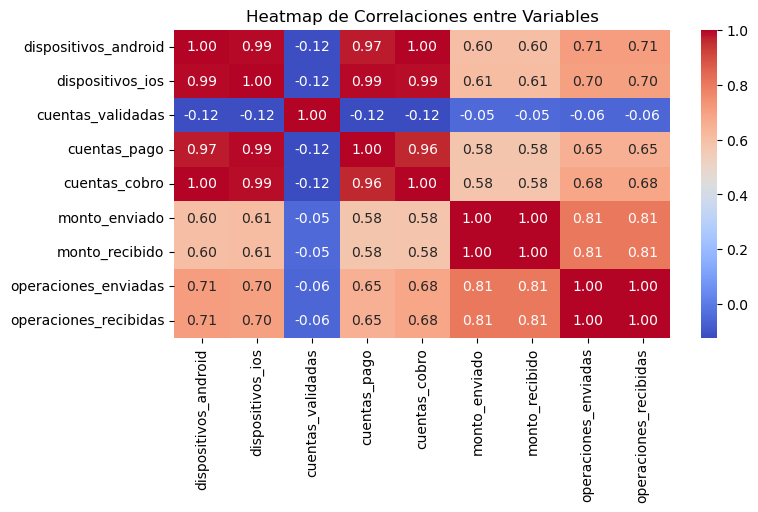

In [106]:
# Matriz de correlaciones
correlaciones = df_final_clean[columnas_numericas].corr()

plt.figure(figsize=(8,4))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de Correlaciones entre Variables')
plt.show()


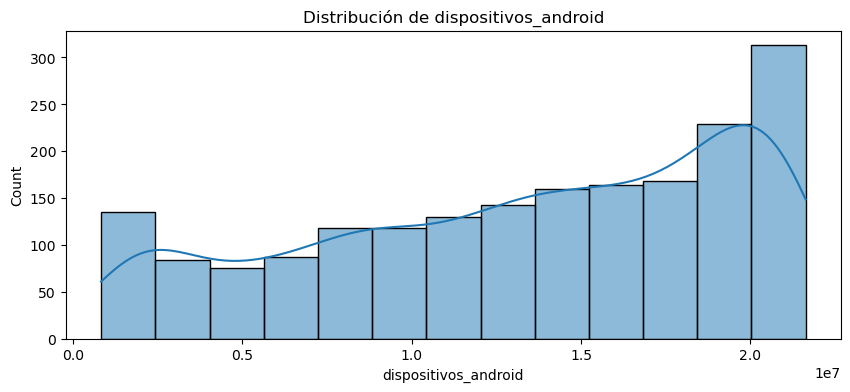

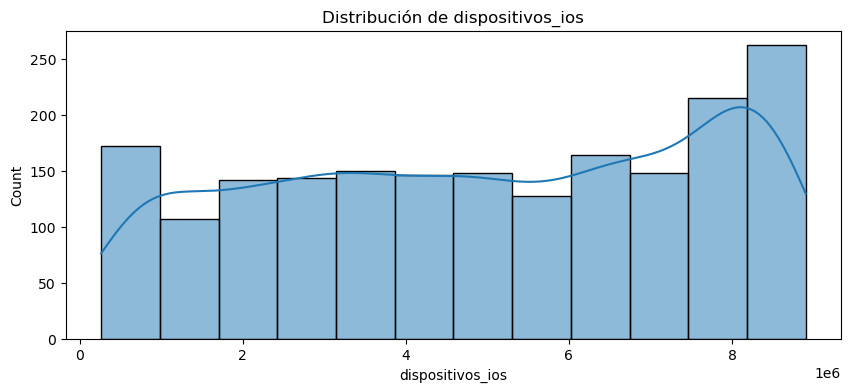

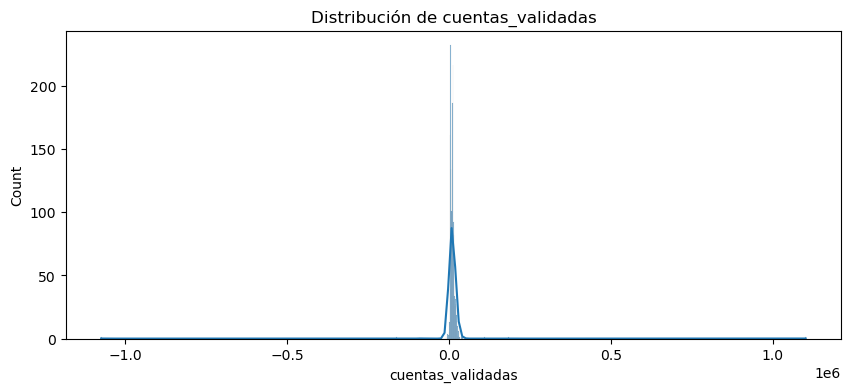

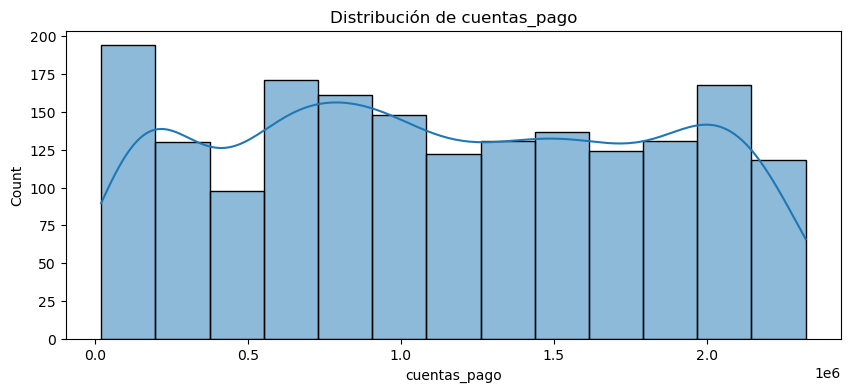

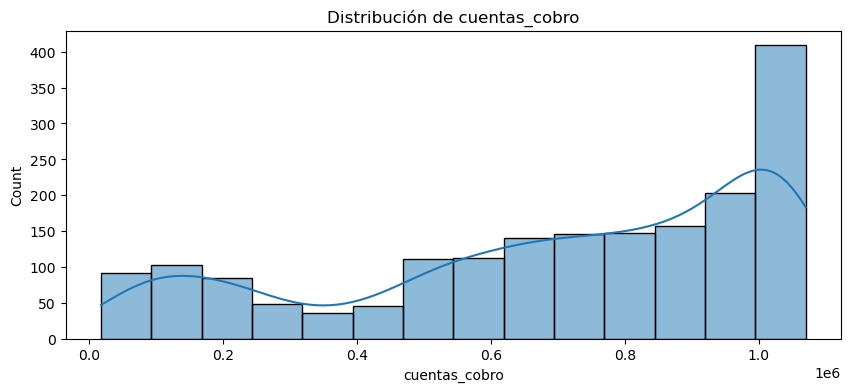

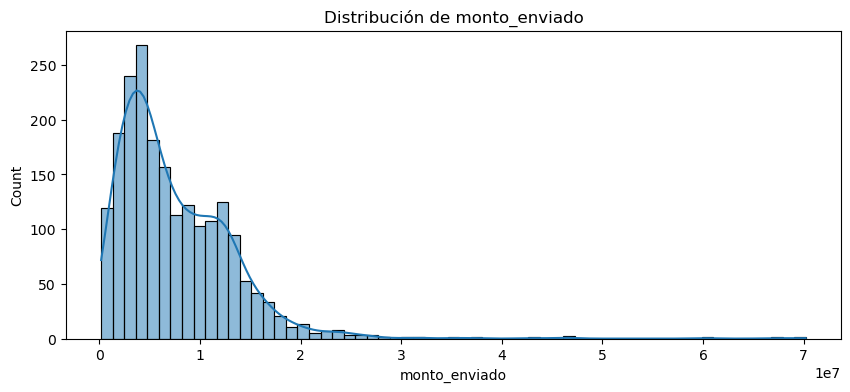

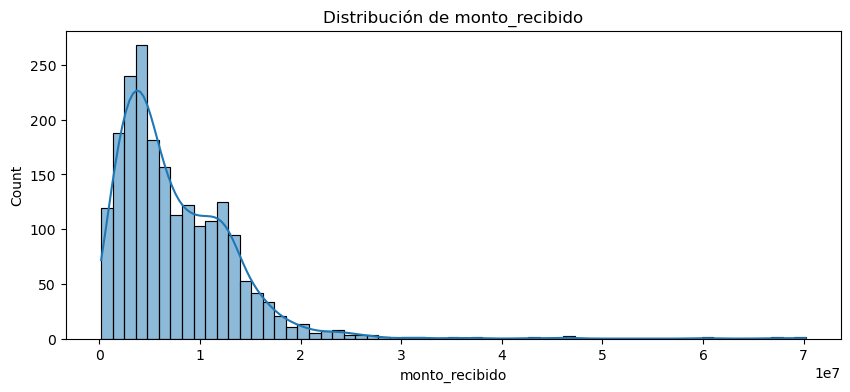

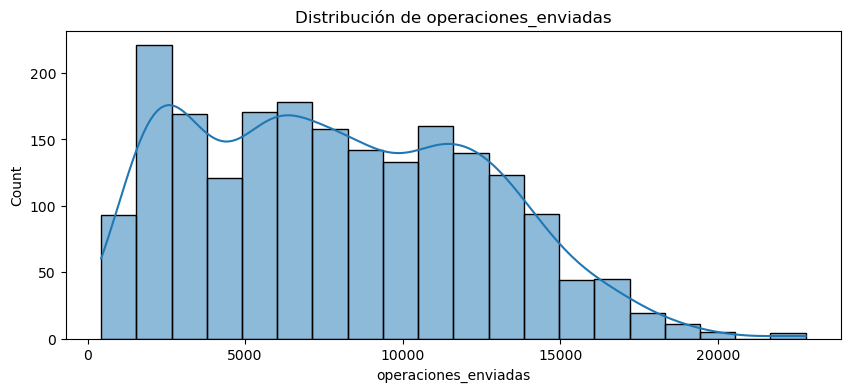

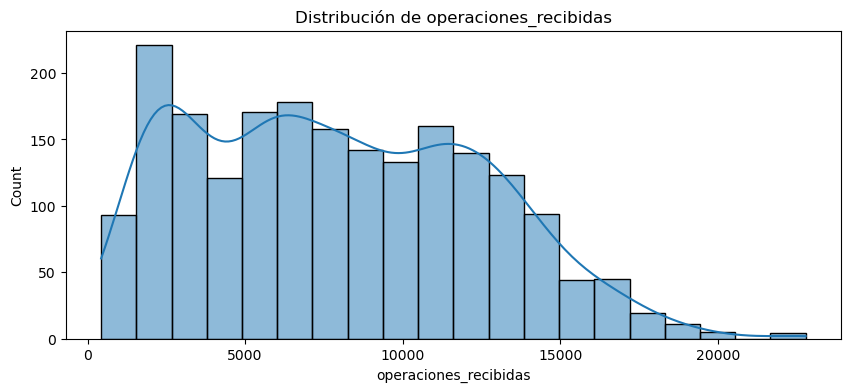

In [105]:
# Gráficas de distribución para cada variable
for col in columnas_numericas:
    plt.figure(figsize=(10,4))
    sns.histplot(df_final_clean[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()


In [107]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Definimos fórmula de modelo
formula = "monto_enviado ~ dispositivos_android + dispositivos_ios + operaciones_enviadas + operaciones_recibidas"

# Preparamos modelo Gamma
modelo = smf.glm(formula=formula,
                 data=df_final_clean,
                 family=sm.families.Gamma(sm.families.links.log())
                 ).fit()

print(modelo.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          monto_enviado   No. Observations:                 1924
Model:                            GLM   Df Residuals:                     1920
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                         0.11973
Method:                          IRLS   Log-Likelihood:                -30636.
Date:                Sun, 27 Apr 2025   Deviance:                       195.66
Time:                        16:51:54   Pearson chi2:                     230.
No. Iterations:                    20   Pseudo R-squ. (CS):             0.9604
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                14.29

/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [108]:
# Variables predictoras
X_vars = [
    'dispositivos_android',
    'dispositivos_ios',
    'operaciones_enviadas',
    'operaciones_recibidas'
]

# Variable objetivo
y_var = 'monto_enviado'

# Creamos X y y
X = df_final_clean[X_vars]
y = df_final_clean[y_var]

# Opcional: eliminar filas que tengan NaN en X o y
datos_modelo = pd.concat([X, y], axis=1).dropna()

X = datos_modelo[X_vars]
y = datos_modelo[y_var]

print(f"✅ Datos preparados: {X.shape[0]} filas")


✅ Datos preparados: 1924 filas


In [109]:
import statsmodels.api as sm

# Añadir intercepto
X = sm.add_constant(X)

# Definir y ajustar el modelo GLM (familia Gamma, link log)
glm_gamma = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.log()))
modelo_ajustado = glm_gamma.fit()

# Resumen del modelo
print(modelo_ajustado.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          monto_enviado   No. Observations:                 1924
Model:                            GLM   Df Residuals:                     1920
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                         0.11973
Method:                          IRLS   Log-Likelihood:                -30636.
Date:                Sun, 27 Apr 2025   Deviance:                       195.66
Time:                        16:53:57   Pearson chi2:                     230.
No. Iterations:                    20   Pseudo R-squ. (CS):             0.9604
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    14.29

/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [110]:
# Interpretación de efectos multiplicativos
import numpy as np

efectos_multiplicativos = np.exp(modelo_ajustado.params)
print("📈 Efectos Multiplicativos (exp(coef)):")
print(efectos_multiplicativos)


📈 Efectos Multiplicativos (exp(coef)):
const                    1.618314e+06
dispositivos_android     1.000000e+00
dispositivos_ios         9.999999e-01
operaciones_enviadas     1.000065e+00
operaciones_recibidas    1.000065e+00
dtype: float64


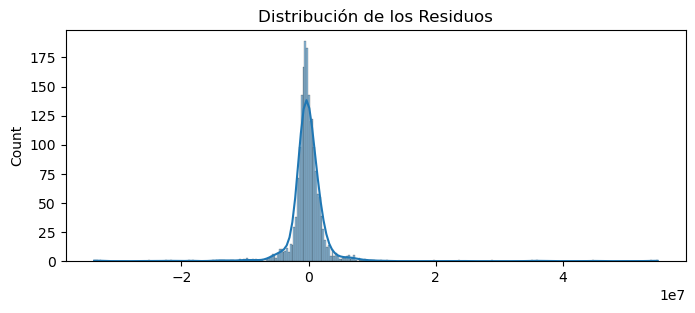

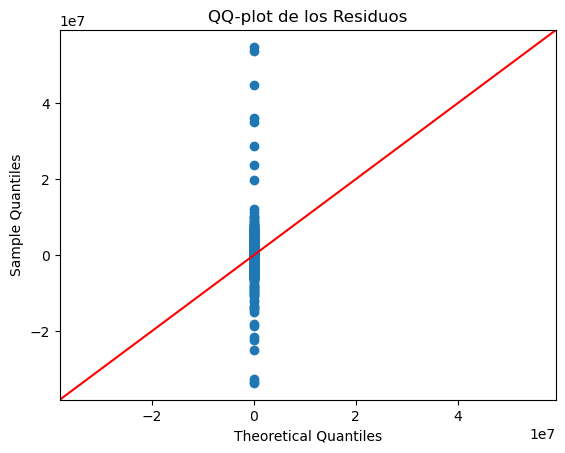

In [113]:
# Residuos
residuos = modelo_ajustado.resid_response

# Histograma de residuos
plt.figure(figsize=(8,3))
sns.histplot(residuos, kde=True)
plt.title("Distribución de los Residuos")
plt.show()

# QQ-plot para ver si los residuos siguen una Gamma (o al menos no son catastróficos)
sm.qqplot(residuos, line='45')
plt.title("QQ-plot de los Residuos")
plt.show()


In [114]:
# Creamos una copia para trabajar seguro
df_modelo_log = df_final_clean.copy()

# Variables a transformar
X_vars = [
    'dispositivos_android',
    'dispositivos_ios',
    'operaciones_enviadas',
    'operaciones_recibidas'
]

# Aplicamos log(1+x) para evitar log(0)
for col in X_vars:
    df_modelo_log[f'log_{col}'] = np.log1p(df_modelo_log[col])

# Nueva lista de variables predictoras transformadas
X_vars_log = [f'log_{col}' for col in X_vars]


In [115]:
# Definir X e y
X = df_modelo_log[X_vars_log]
y = df_modelo_log['monto_enviado']

# Eliminar filas con NaN
datos_modelo = pd.concat([X, y], axis=1).dropna()
X = datos_modelo[X_vars_log]
y = datos_modelo['monto_enviado']

# Añadir intercepto
X = sm.add_constant(X)

# Ajustar modelo GLM Gamma
glm_gamma_log = sm.GLM(y, X, family=sm.families.Gamma(sm.families.links.log()))
modelo_log_ajustado = glm_gamma_log.fit()

# Mostrar resumen
print(modelo_log_ajustado.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          monto_enviado   No. Observations:                 1924
Model:                            GLM   Df Residuals:                     1920
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                         0.10740
Method:                          IRLS   Log-Likelihood:                -30471.
Date:                Sun, 27 Apr 2025   Deviance:                       162.95
Time:                        16:58:11   Pearson chi2:                     206.
No. Iterations:                    18   Pseudo R-squ. (CS):             0.9767
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/opt/homebrew/Caskroom/miniconda/base/envs/arquitectura/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


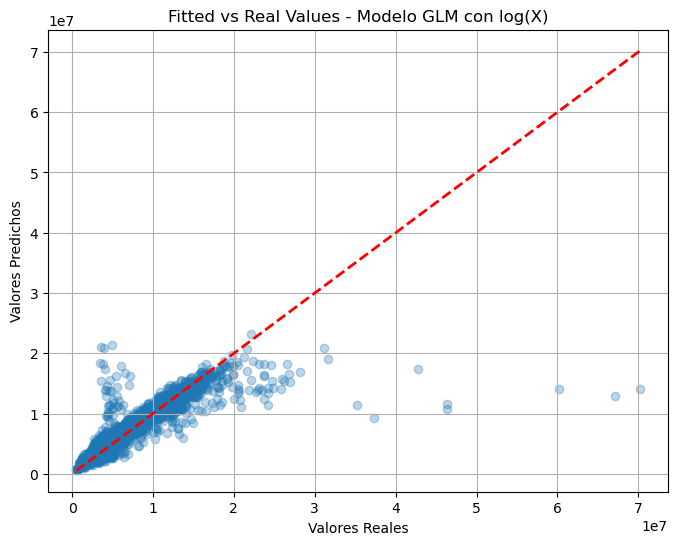

In [118]:
# Predicciones
fitted_values = modelo_log_ajustado.fittedvalues

# Graficar
plt.figure(figsize=(8,6))
plt.scatter(y, fitted_values, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Fitted vs Real Values - Modelo GLM con log(X)')
plt.grid(True)
plt.show()
